In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
import matplotlib.pyplot as plt
import scipy 
from scipy import stats
import seaborn as sns

from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import StandardScaler





from catboost import CatBoostClassifier, Pool, cv



#ignore warnings
import warnings
warnings.filterwarnings('ignore')


## | Table of content




### Problem statement

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

Heart failure is a common, costly, and potentially fatal condition. It is the leading cause of both hospitalization and re-admission amongst older adults. Heart failure often results in more drastic detrimental health effects compared to failure of other similarly complex organs such as the kidneys or liver. In 2015, it affected about 40 million people globally. Overall around 2% of adults have heart failure and in those over the age of 65, this increases to 6–10%. The risk of death is about 35% the first year after diagnosis, while by the second year the risk of death is less than 10% for those who remain alive

### Data pre-processing

In [3]:
heart_data = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
print(heart_data.shape)
heart_data

(299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [4]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
heart_data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
heart_data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    return df
heart_data = reduce_memory_usage(heart_data)

### Data description

In [8]:
heart_data.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

age : Patient age (years) <br>
anaemia : decrease of red blood cells or hemoglobin (boolean); [1: True; 0: False] <br>
creatinine_phosphokinase : level of the CPK enzyme in the blood [mcg/L] <br>
diabetes : if the patient has diabetes (boolean); [1: True; 0: False] <br>
ejection_fraction : percentage of blood leaving the heart at each contraction (percentage) <br>
high_blood_pressure : if the patient has hypertension (boolean); [1: True; 0: False] <br>
platelets : platelets in the blood (kiloplatelets/mL) <br>
serum_creatinine : level of serum creatinine in the blood (mg/dL) <br>
serum_sodium : level of serum sodium in the blood (mEq/L) <br>
sex : male or female (binary) [1: Male, 0: Female] <br>
smoking : if the patient smokes or not (boolean) [1: True; 0: False] <br>
time : follow-up period (days) <br>
DEATH_EVENT : if the patient deceased during the follow-up period (boolean) [1: True; 0: False] <br>

### Exploratory Data Analysis

In [9]:
plt.style.use("ggplot")  #seaborn-whitegrid
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [10]:
plot_heart_data = heart_data.copy()
death_event =  {0:'Survived',1:'Died'}
plot_heart_data.DEATH_EVENT = plot_heart_data.DEATH_EVENT.map(death_event)
plot_heart_data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00000,1.900391,130,1,0,4,Died
1,55.0,0,7861,0,38,0,263358.03125,1.099609,136,1,0,6,Died
2,65.0,0,146,0,20,0,162000.00000,1.299805,129,1,1,7,Died
3,50.0,1,111,0,20,0,210000.00000,1.900391,137,1,0,7,Died
4,65.0,1,160,1,20,0,327000.00000,2.699219,116,0,0,8,Died
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00000,1.099609,143,1,1,270,Survived
295,55.0,0,1820,0,38,0,270000.00000,1.200195,139,0,0,271,Survived
296,45.0,0,2060,1,60,0,742000.00000,0.799805,138,0,0,278,Survived
297,45.0,0,2413,0,38,0,140000.00000,1.400391,140,1,1,280,Survived


In [11]:
print(f'{round(heart_data.DEATH_EVENT.value_counts()[0]/len(heart_data.DEATH_EVENT)*100,2)}% of patients survived')
print(f'{round(heart_data.DEATH_EVENT.value_counts()[1]/len(heart_data.DEATH_EVENT)*100,2)}% of patients died')

67.89% of patients survived
32.11% of patients died


<AxesSubplot:xlabel='age', ylabel='Count'>

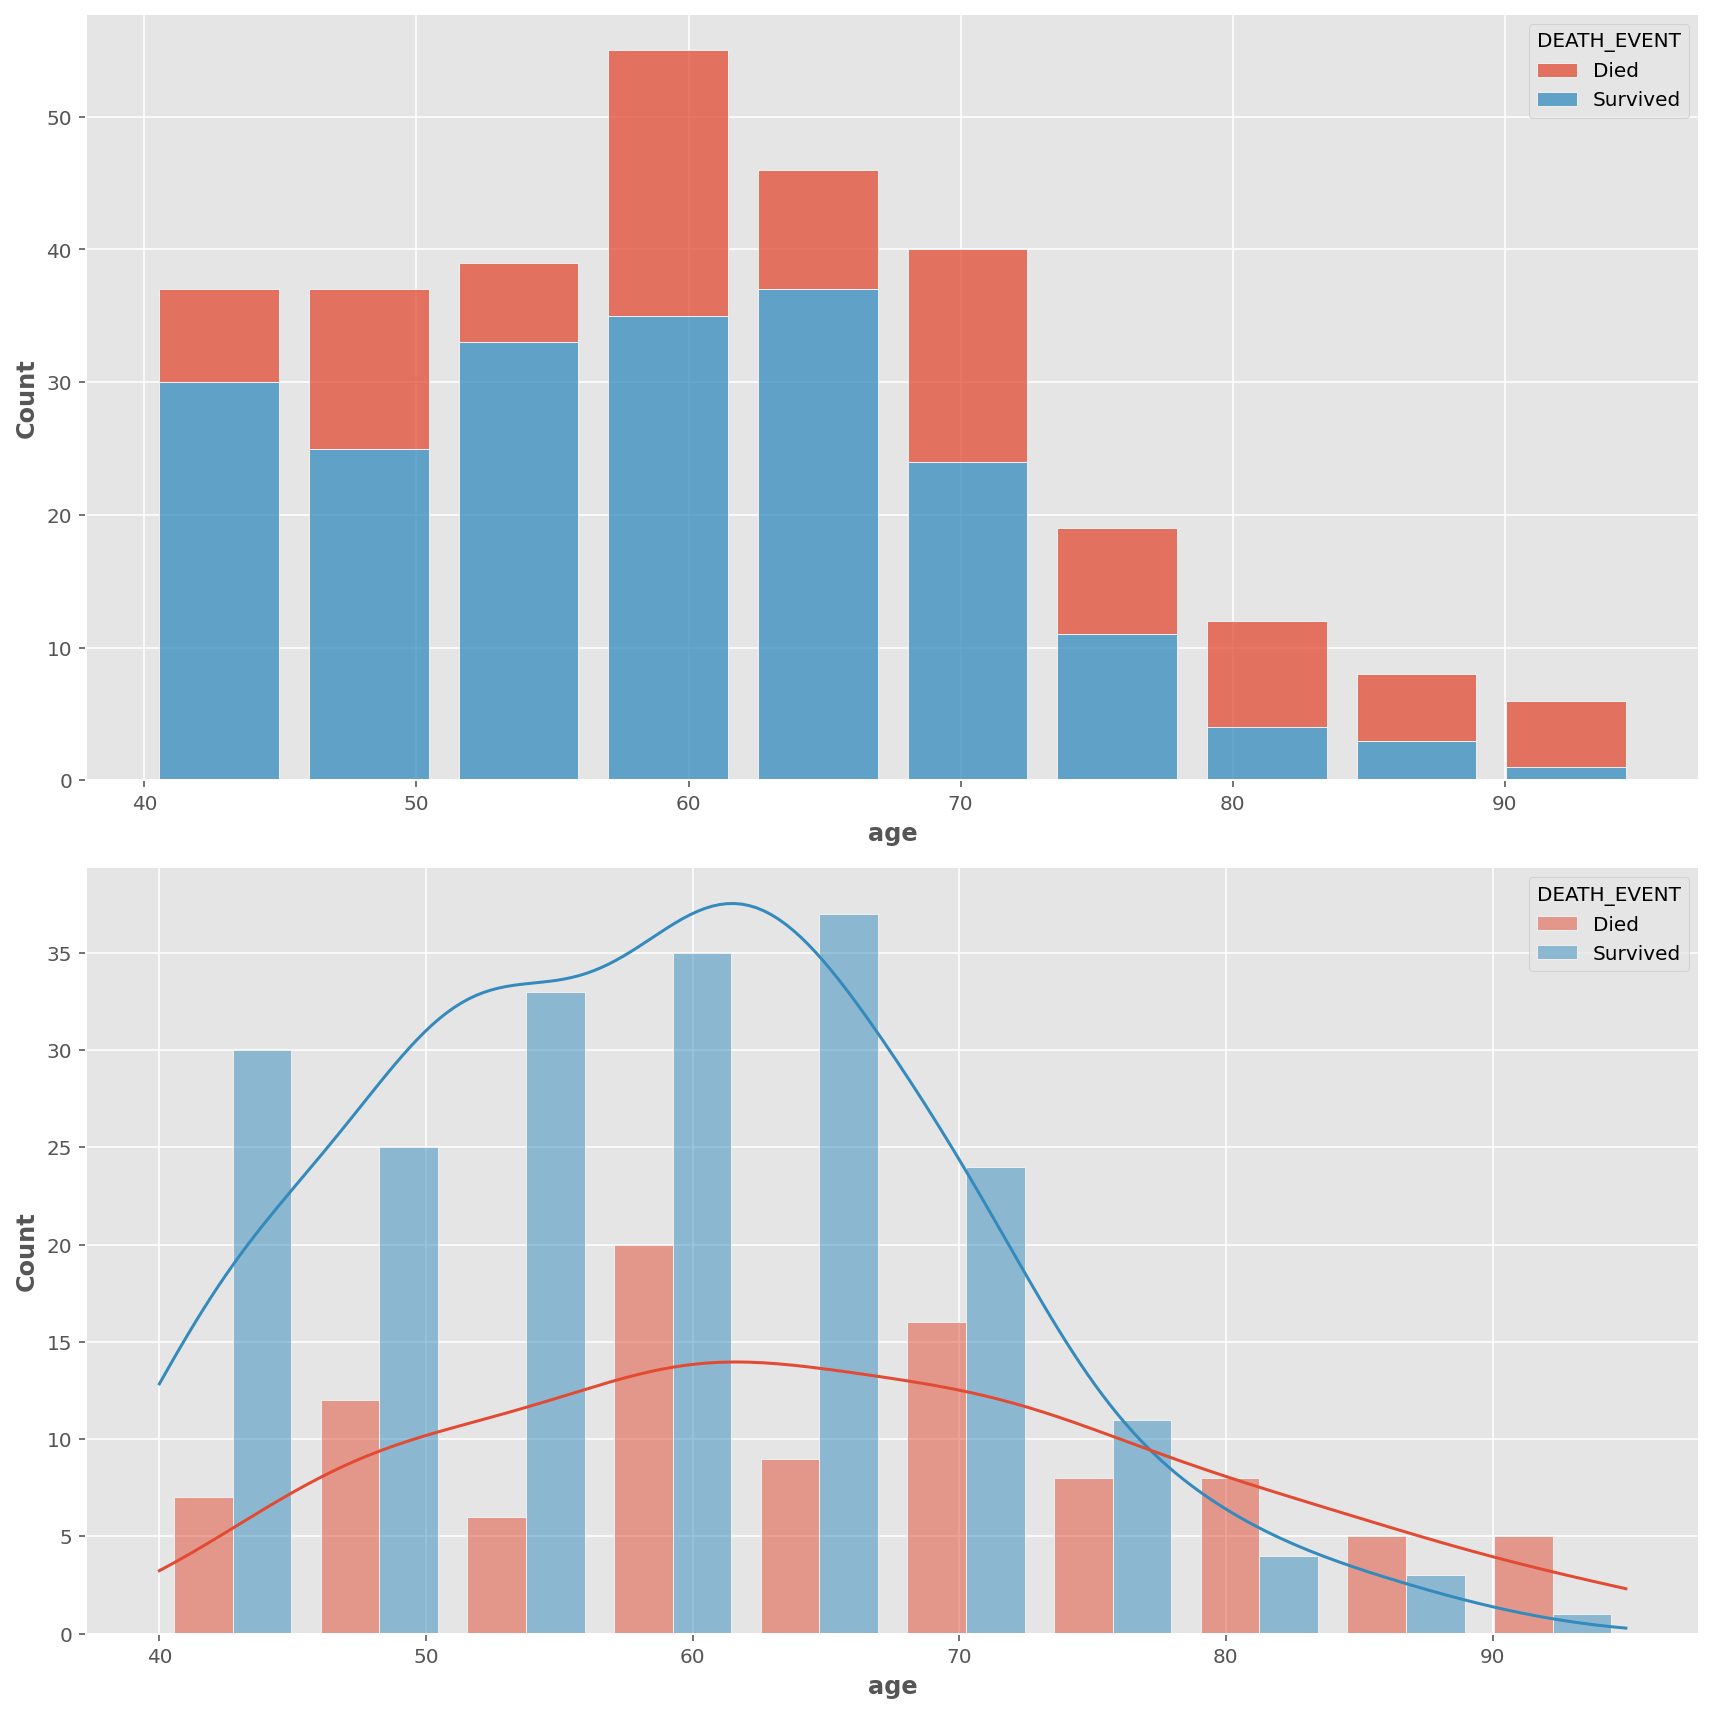

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="age", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="age",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)

<AxesSubplot:xlabel='anaemia', ylabel='Percent'>

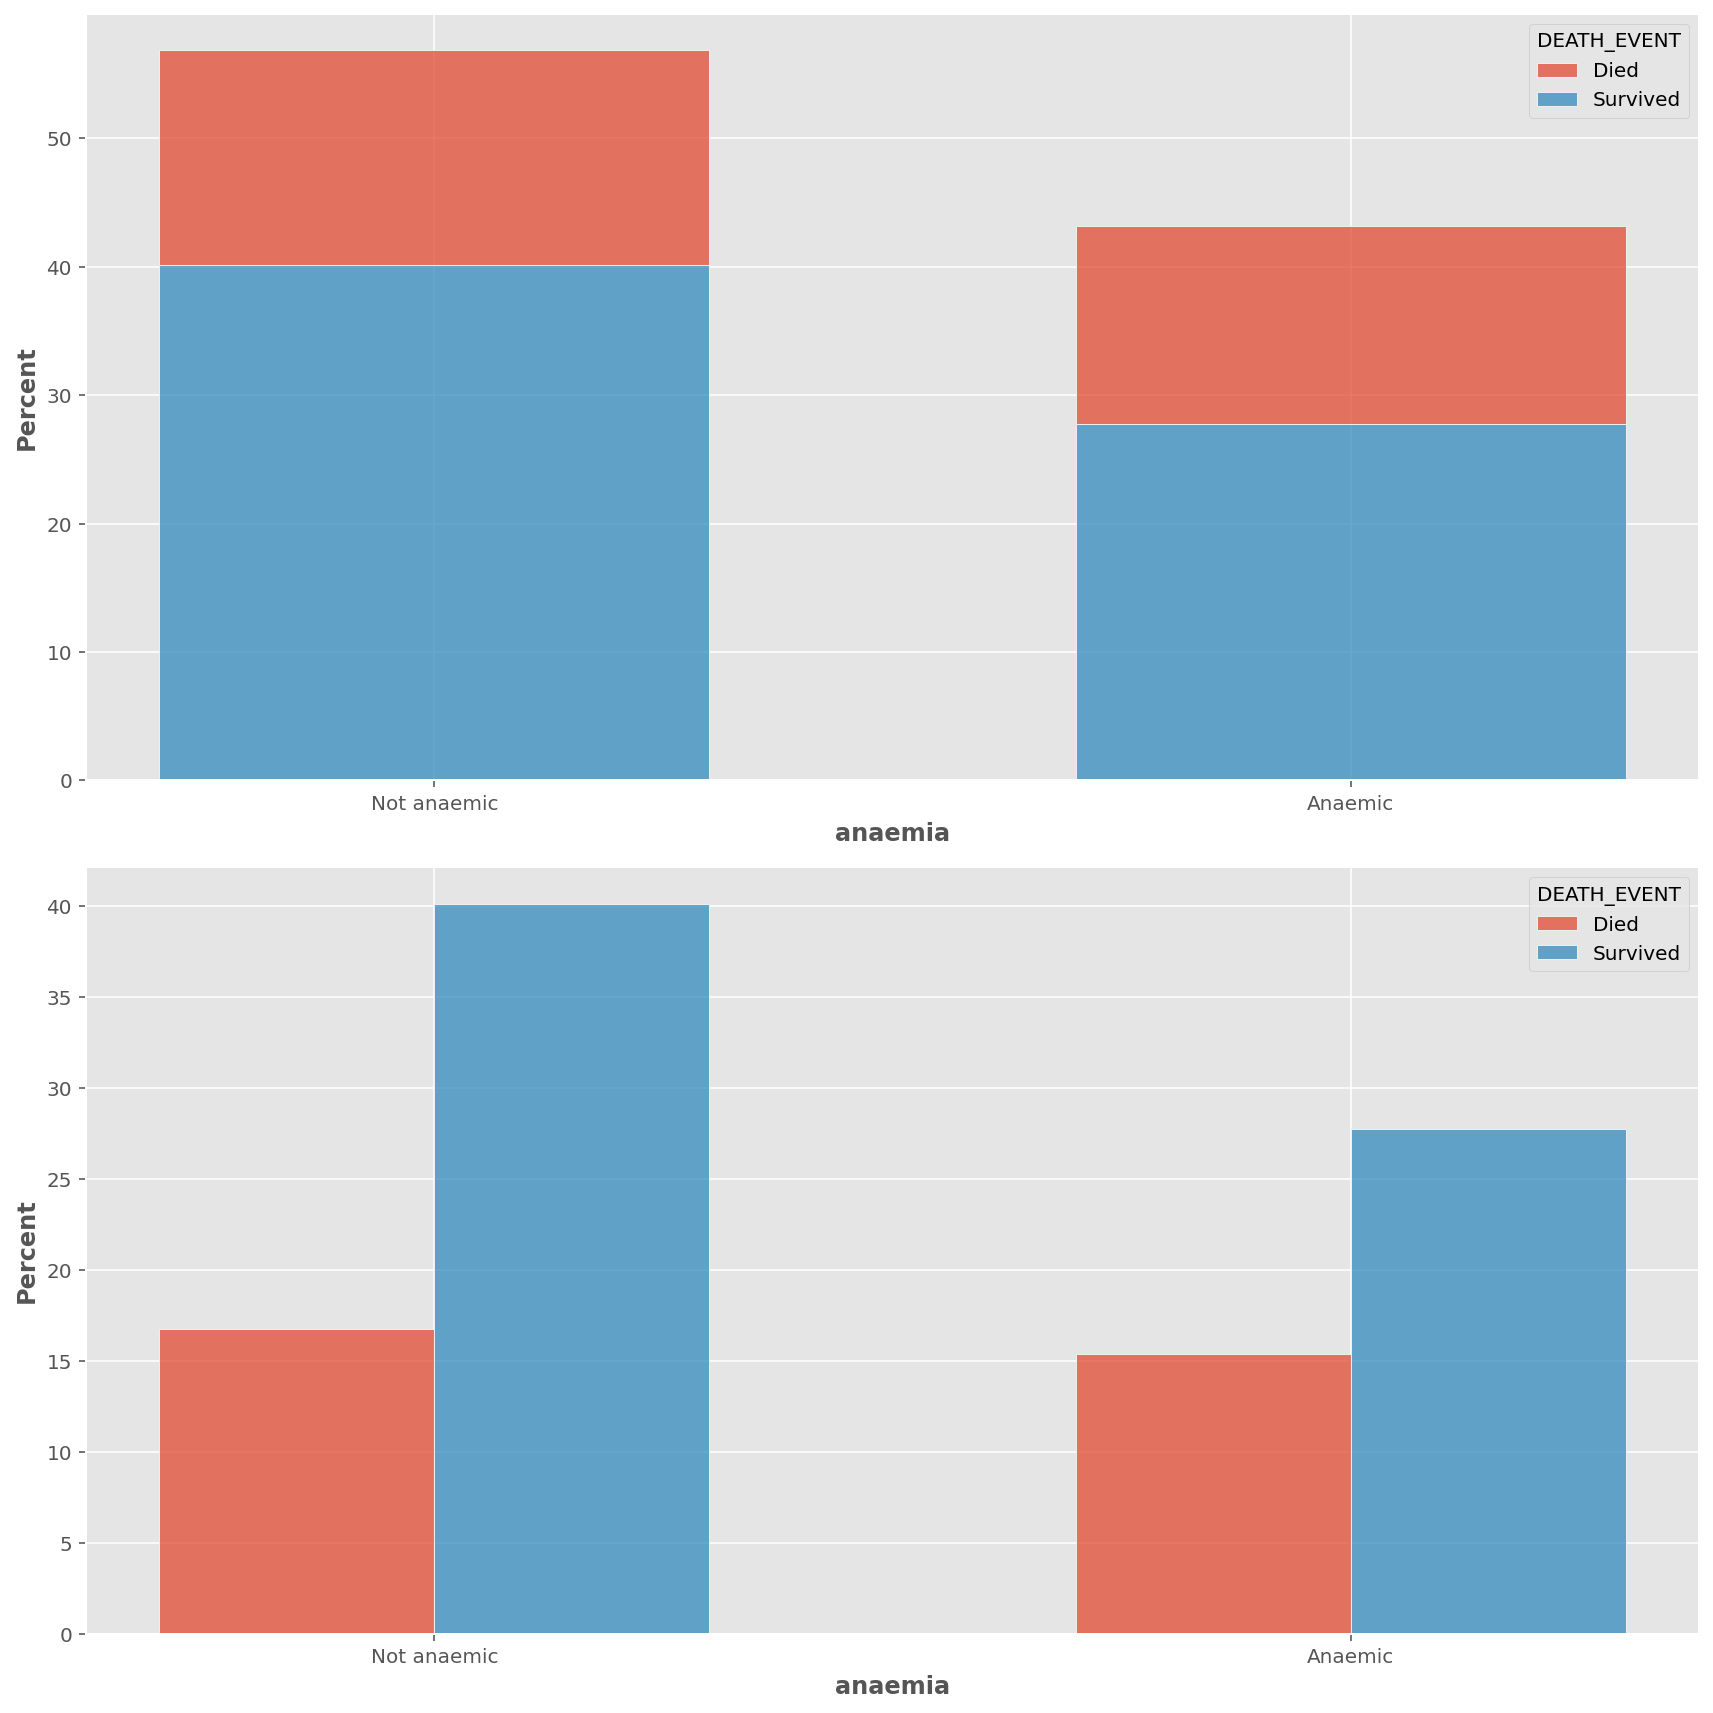

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
anaemia =  {0:'Not anaemic',1:'Anaemic'}
anaemic = plot_heart_data.anaemia.map(anaemia)
sns.histplot(data=plot_heart_data, x= anaemic, hue="DEATH_EVENT", multiple="stack",stat= 'percent', shrink=.6, ax=ax1)
sns.histplot(data=plot_heart_data, x= anaemic, multiple="dodge", shrink=.6, stat='percent' ,hue="DEATH_EVENT",ax=ax2)

<AxesSubplot:xlabel='creatinine_phosphokinase', ylabel='Count'>

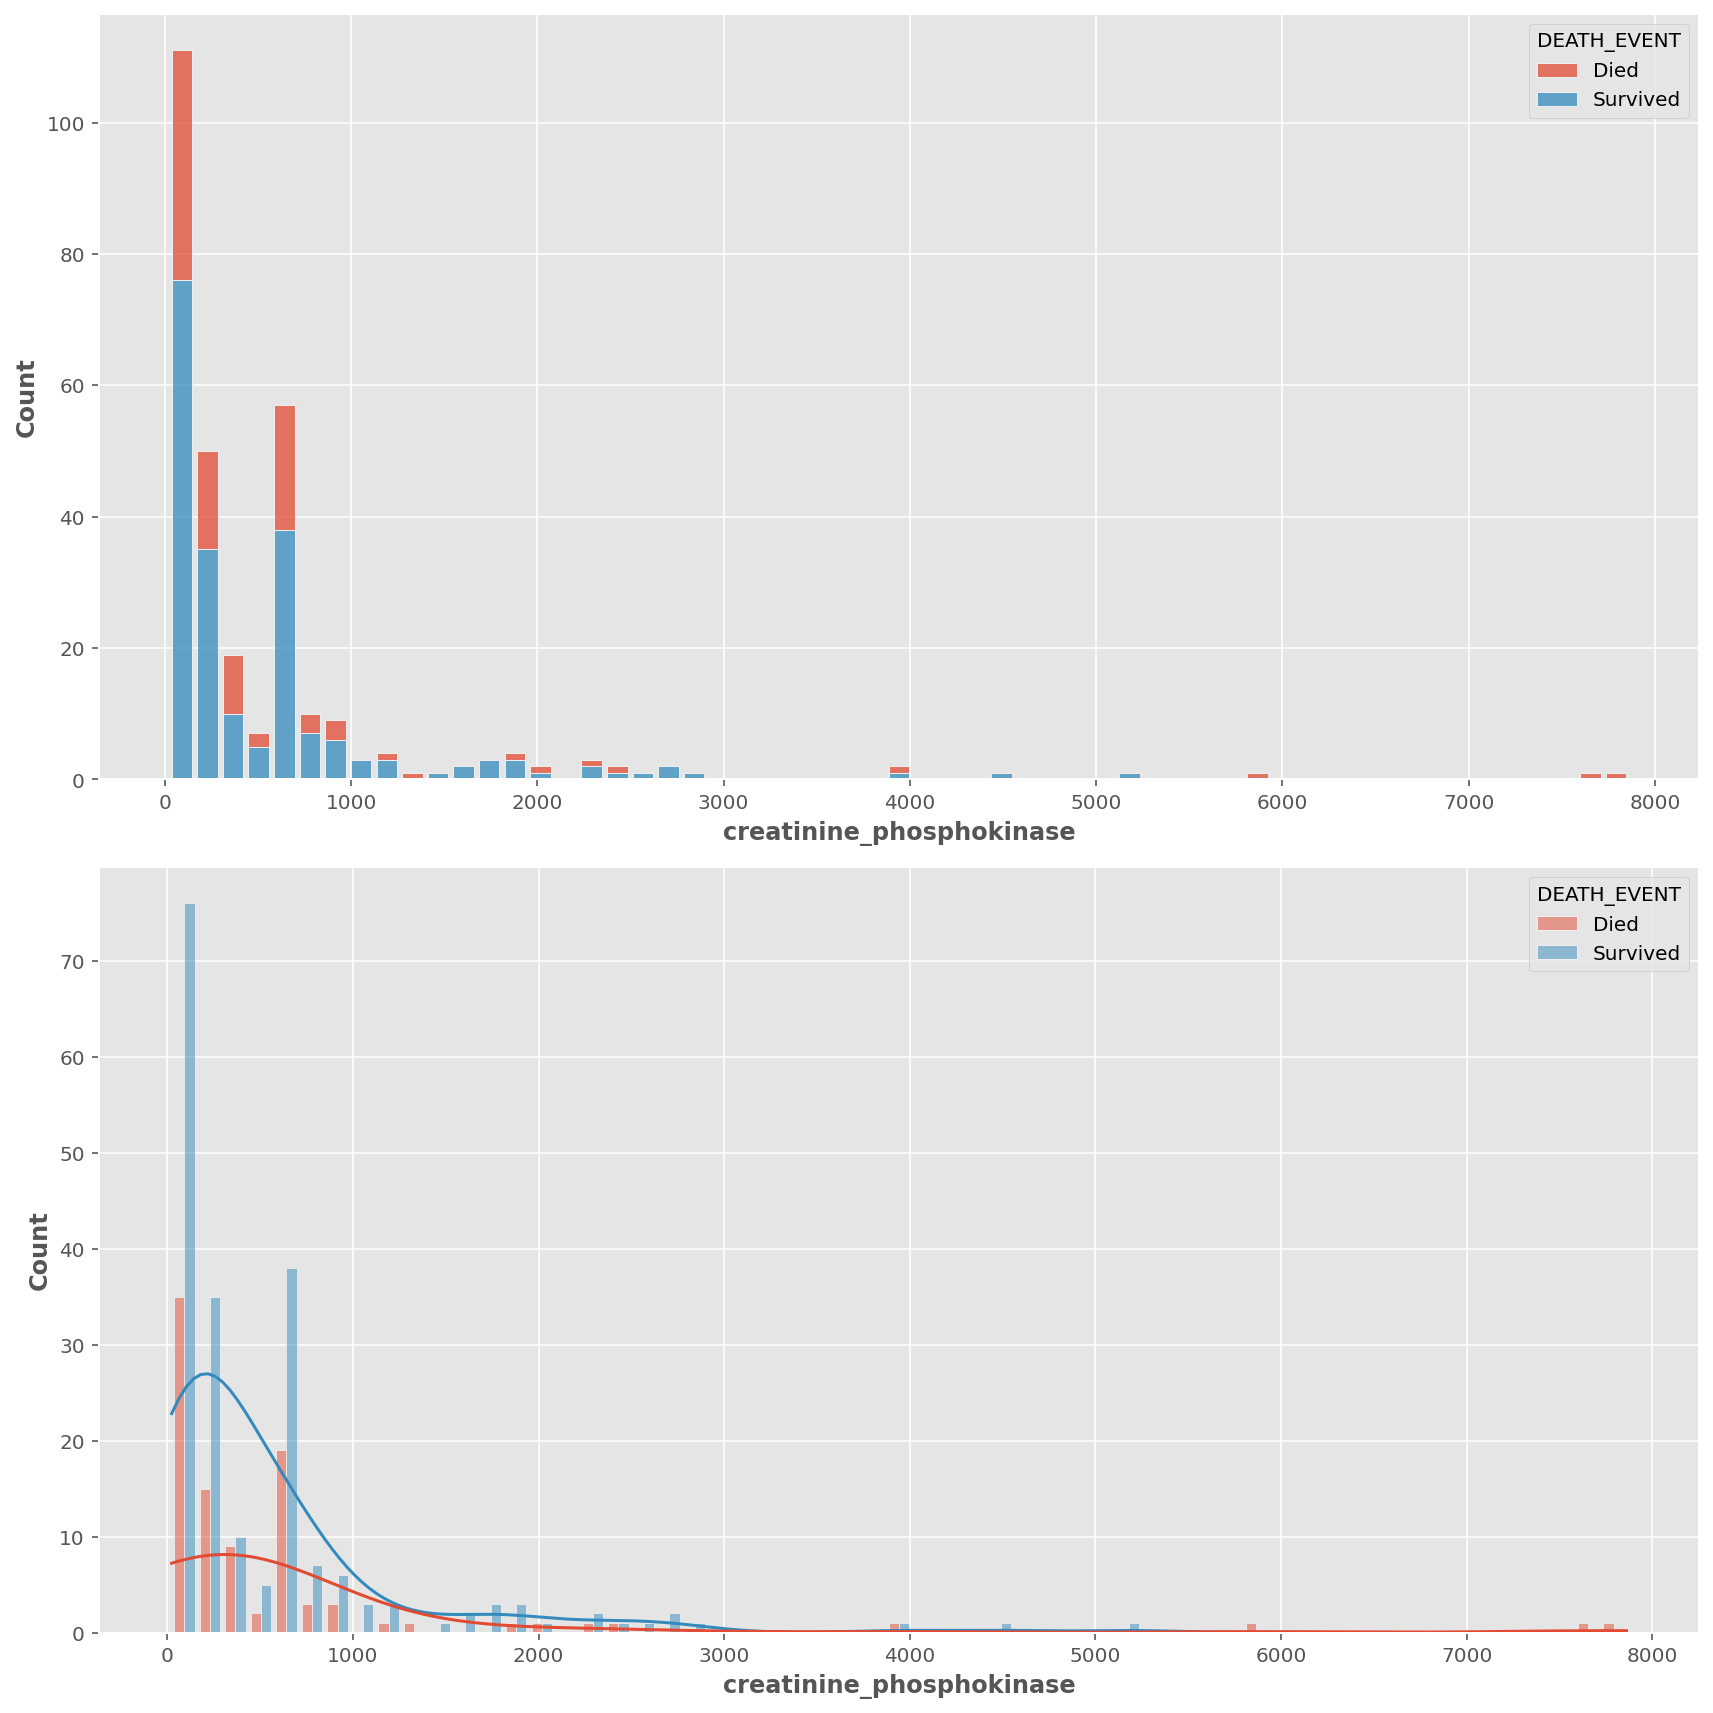

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="creatinine_phosphokinase", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="creatinine_phosphokinase",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)

<AxesSubplot:xlabel='creatinine_phosphokinase', ylabel='Density'>

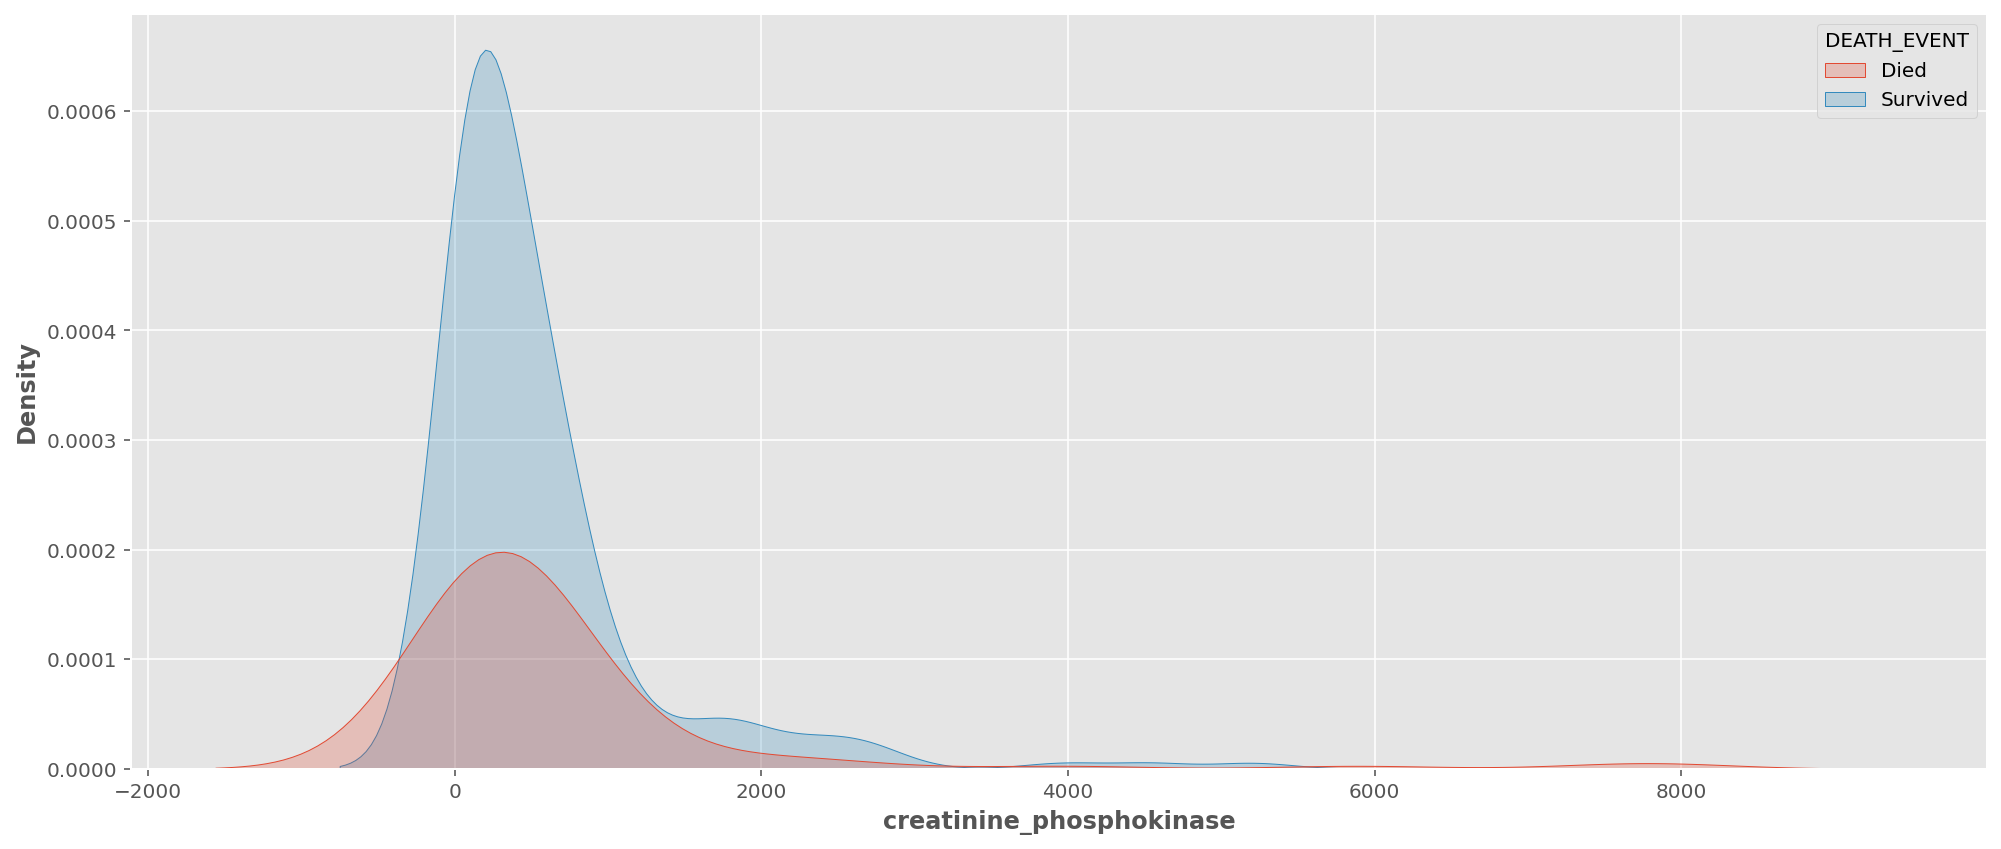

In [15]:
#std =stats.zscore(plot_heart_data.creatinine_phosphokinase)
plt.figure(figsize=(14, 6))
sns.kdeplot(data=plot_heart_data, x = 'creatinine_phosphokinase', hue="DEATH_EVENT",shade=True) #x = std for distribution

<AxesSubplot:xlabel='diabetes', ylabel='Percent'>

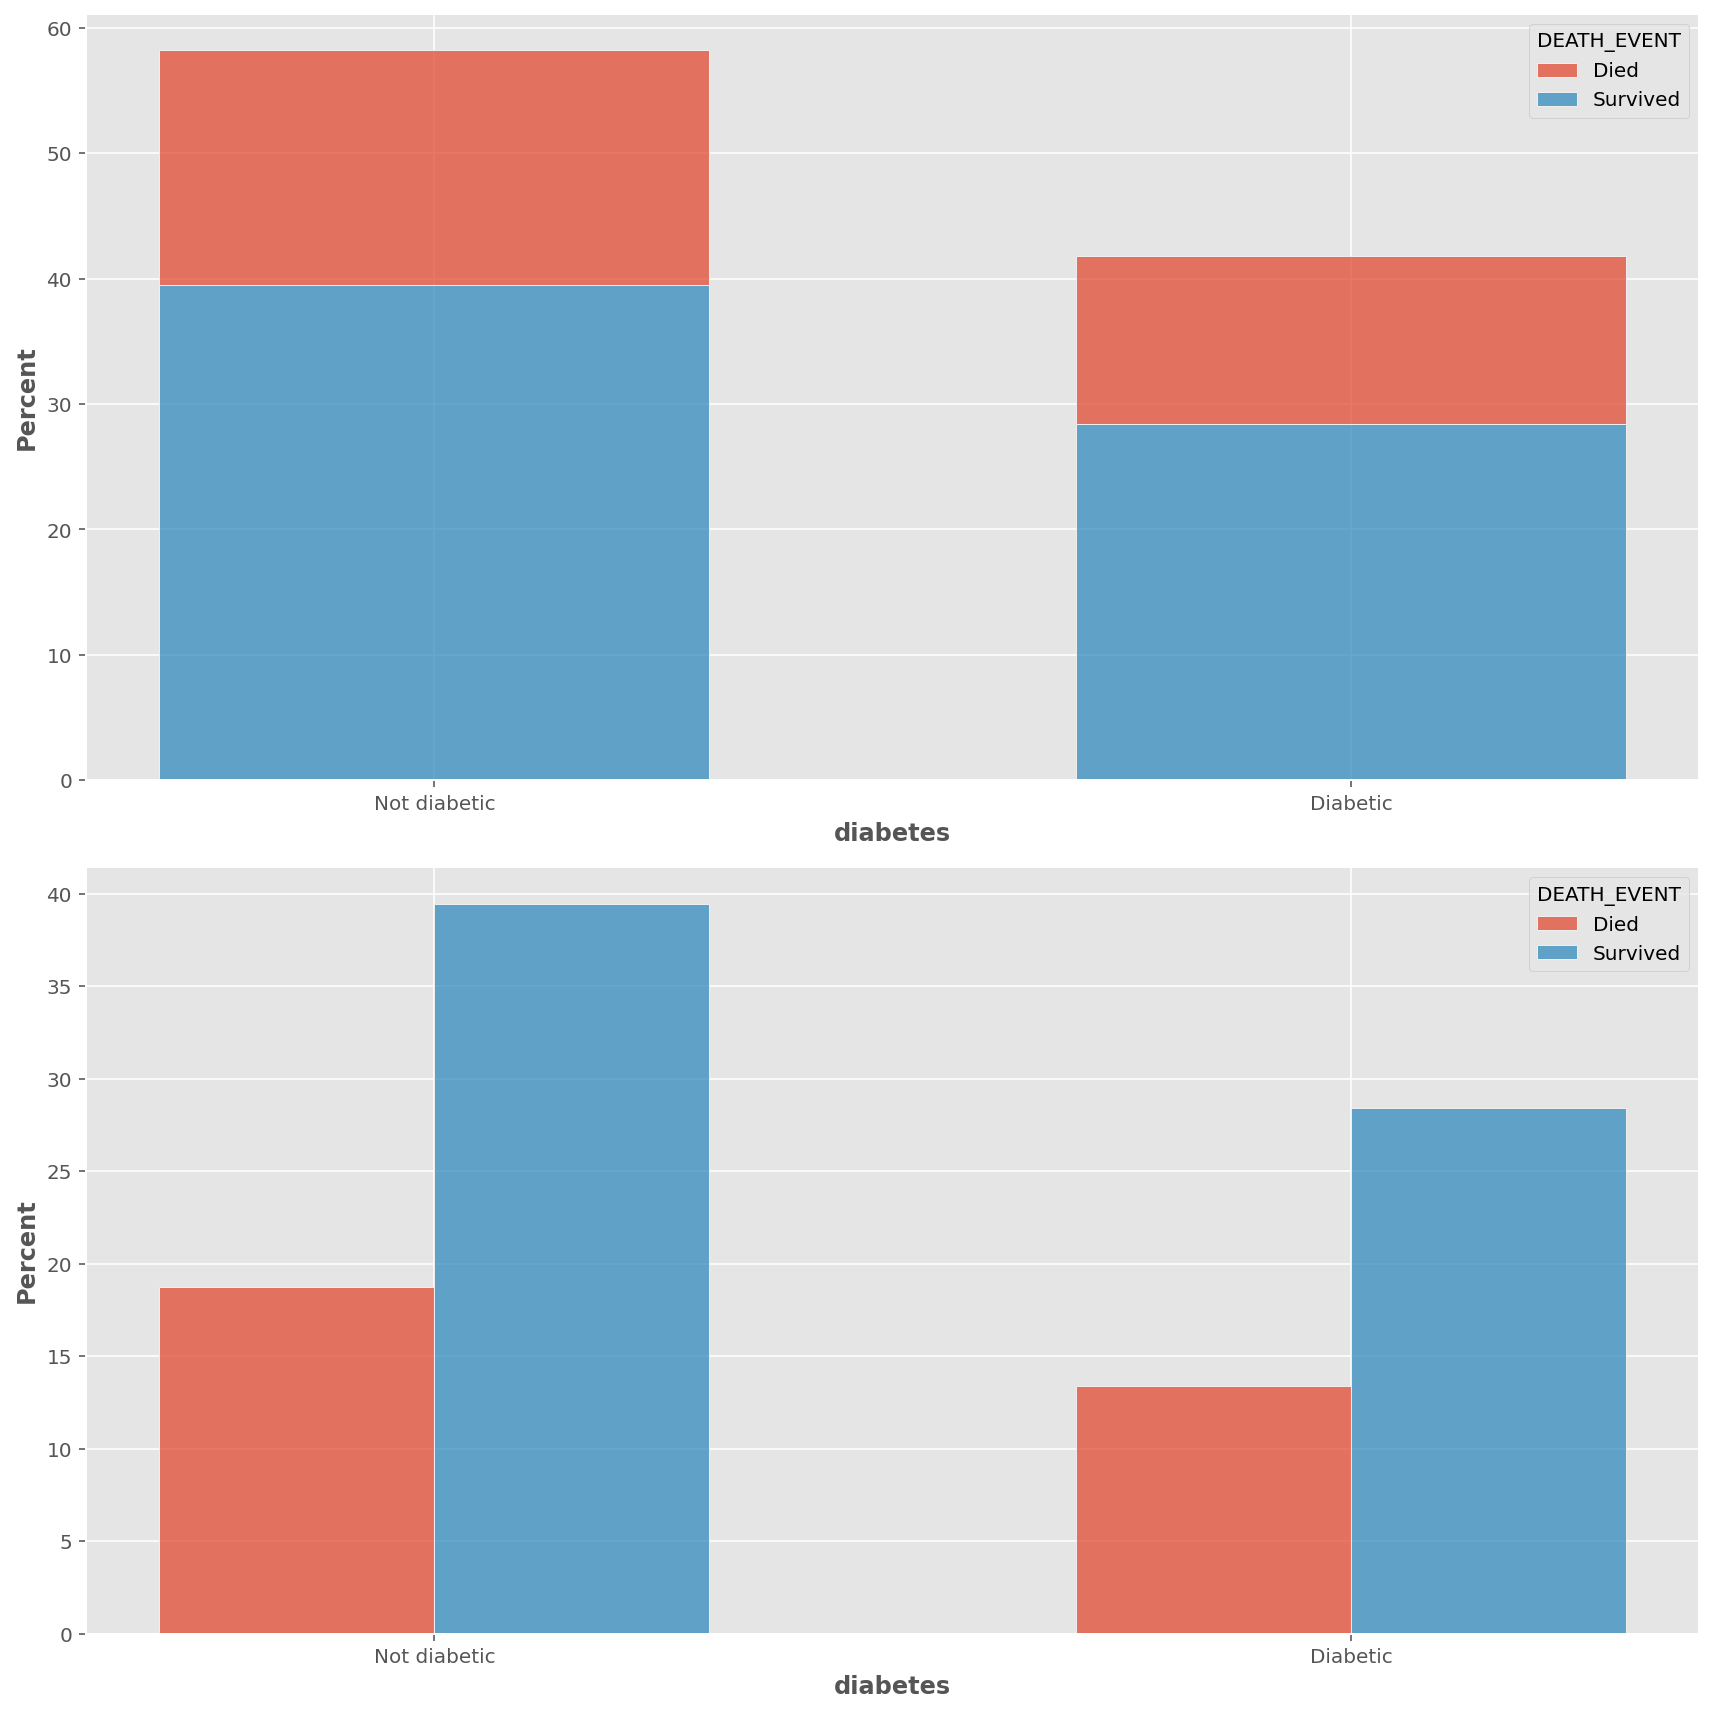

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
diabetes =  {0:'Not diabetic',1:'Diabetic'}
diabetic = plot_heart_data.diabetes.map(diabetes)
sns.histplot(data=plot_heart_data, x= diabetic, hue="DEATH_EVENT", multiple="stack",stat= 'percent', shrink=.6, ax=ax1)
sns.histplot(data=plot_heart_data, x= diabetic, multiple="dodge", shrink=.6, stat='percent' ,hue="DEATH_EVENT",ax=ax2)

<AxesSubplot:xlabel='ejection_fraction', ylabel='Count'>

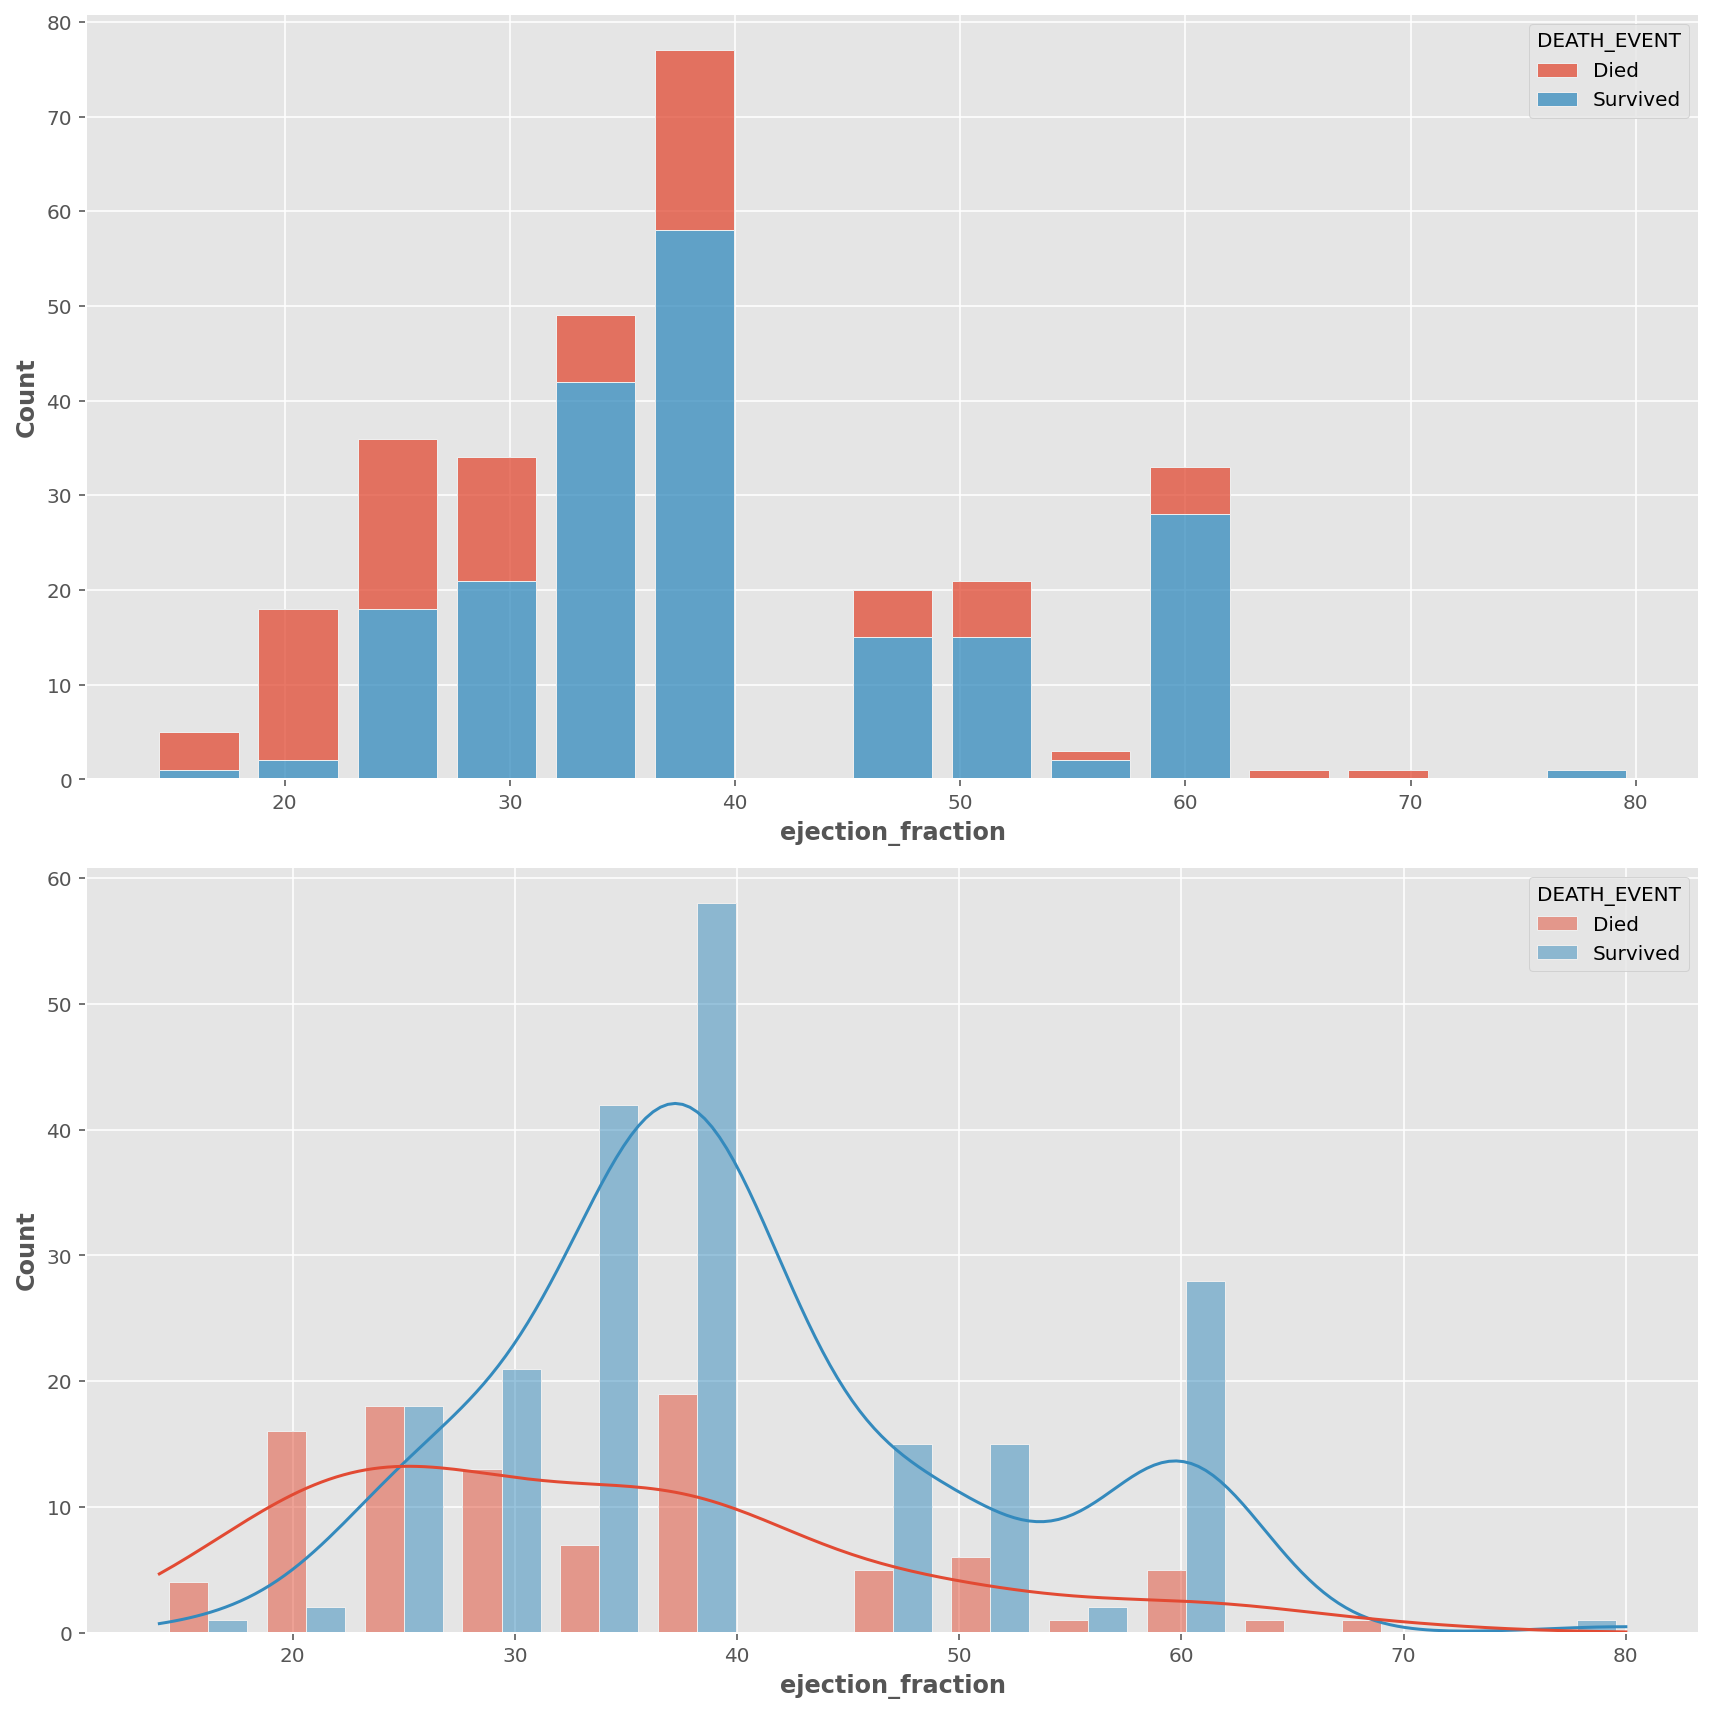

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="ejection_fraction", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="ejection_fraction",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)

<AxesSubplot:xlabel='high_blood_pressure', ylabel='Percent'>

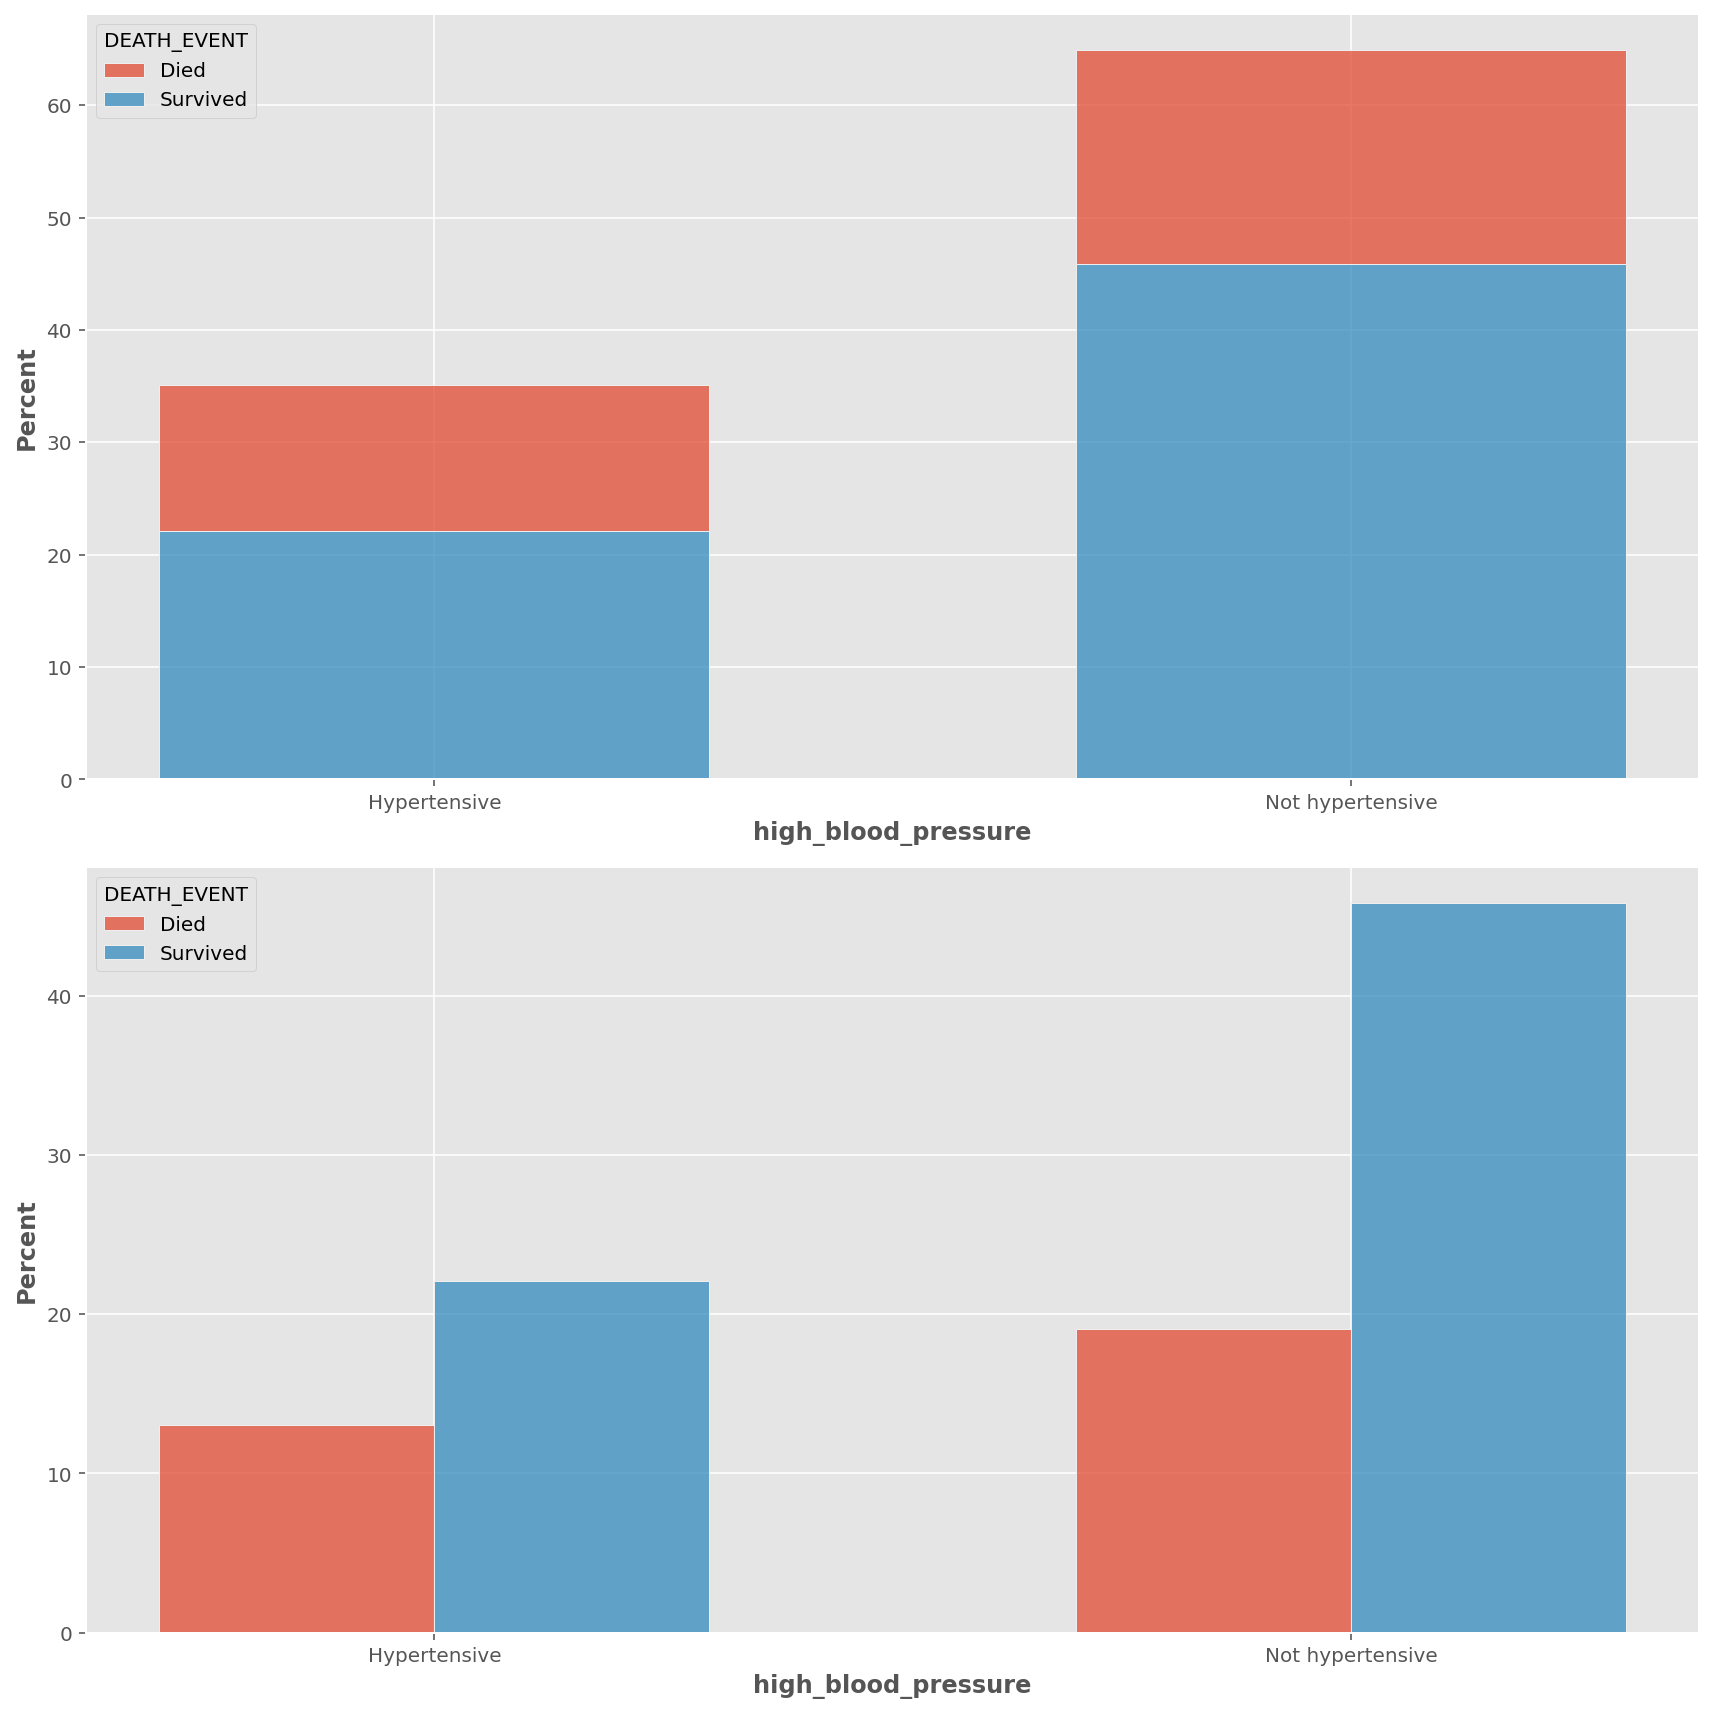

In [18]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
hyper =  {0:'Not hypertensive',1:'Hypertensive'}
hypertensive = plot_heart_data.high_blood_pressure.map(hyper)
sns.histplot(data=plot_heart_data, x= hypertensive, hue="DEATH_EVENT", multiple="stack",stat= 'percent', shrink=.6, ax=ax1)
sns.histplot(data=plot_heart_data, x= hypertensive, multiple="dodge", shrink=.6, stat='percent' ,hue="DEATH_EVENT",ax=ax2)

<AxesSubplot:xlabel='platelets', ylabel='Count'>

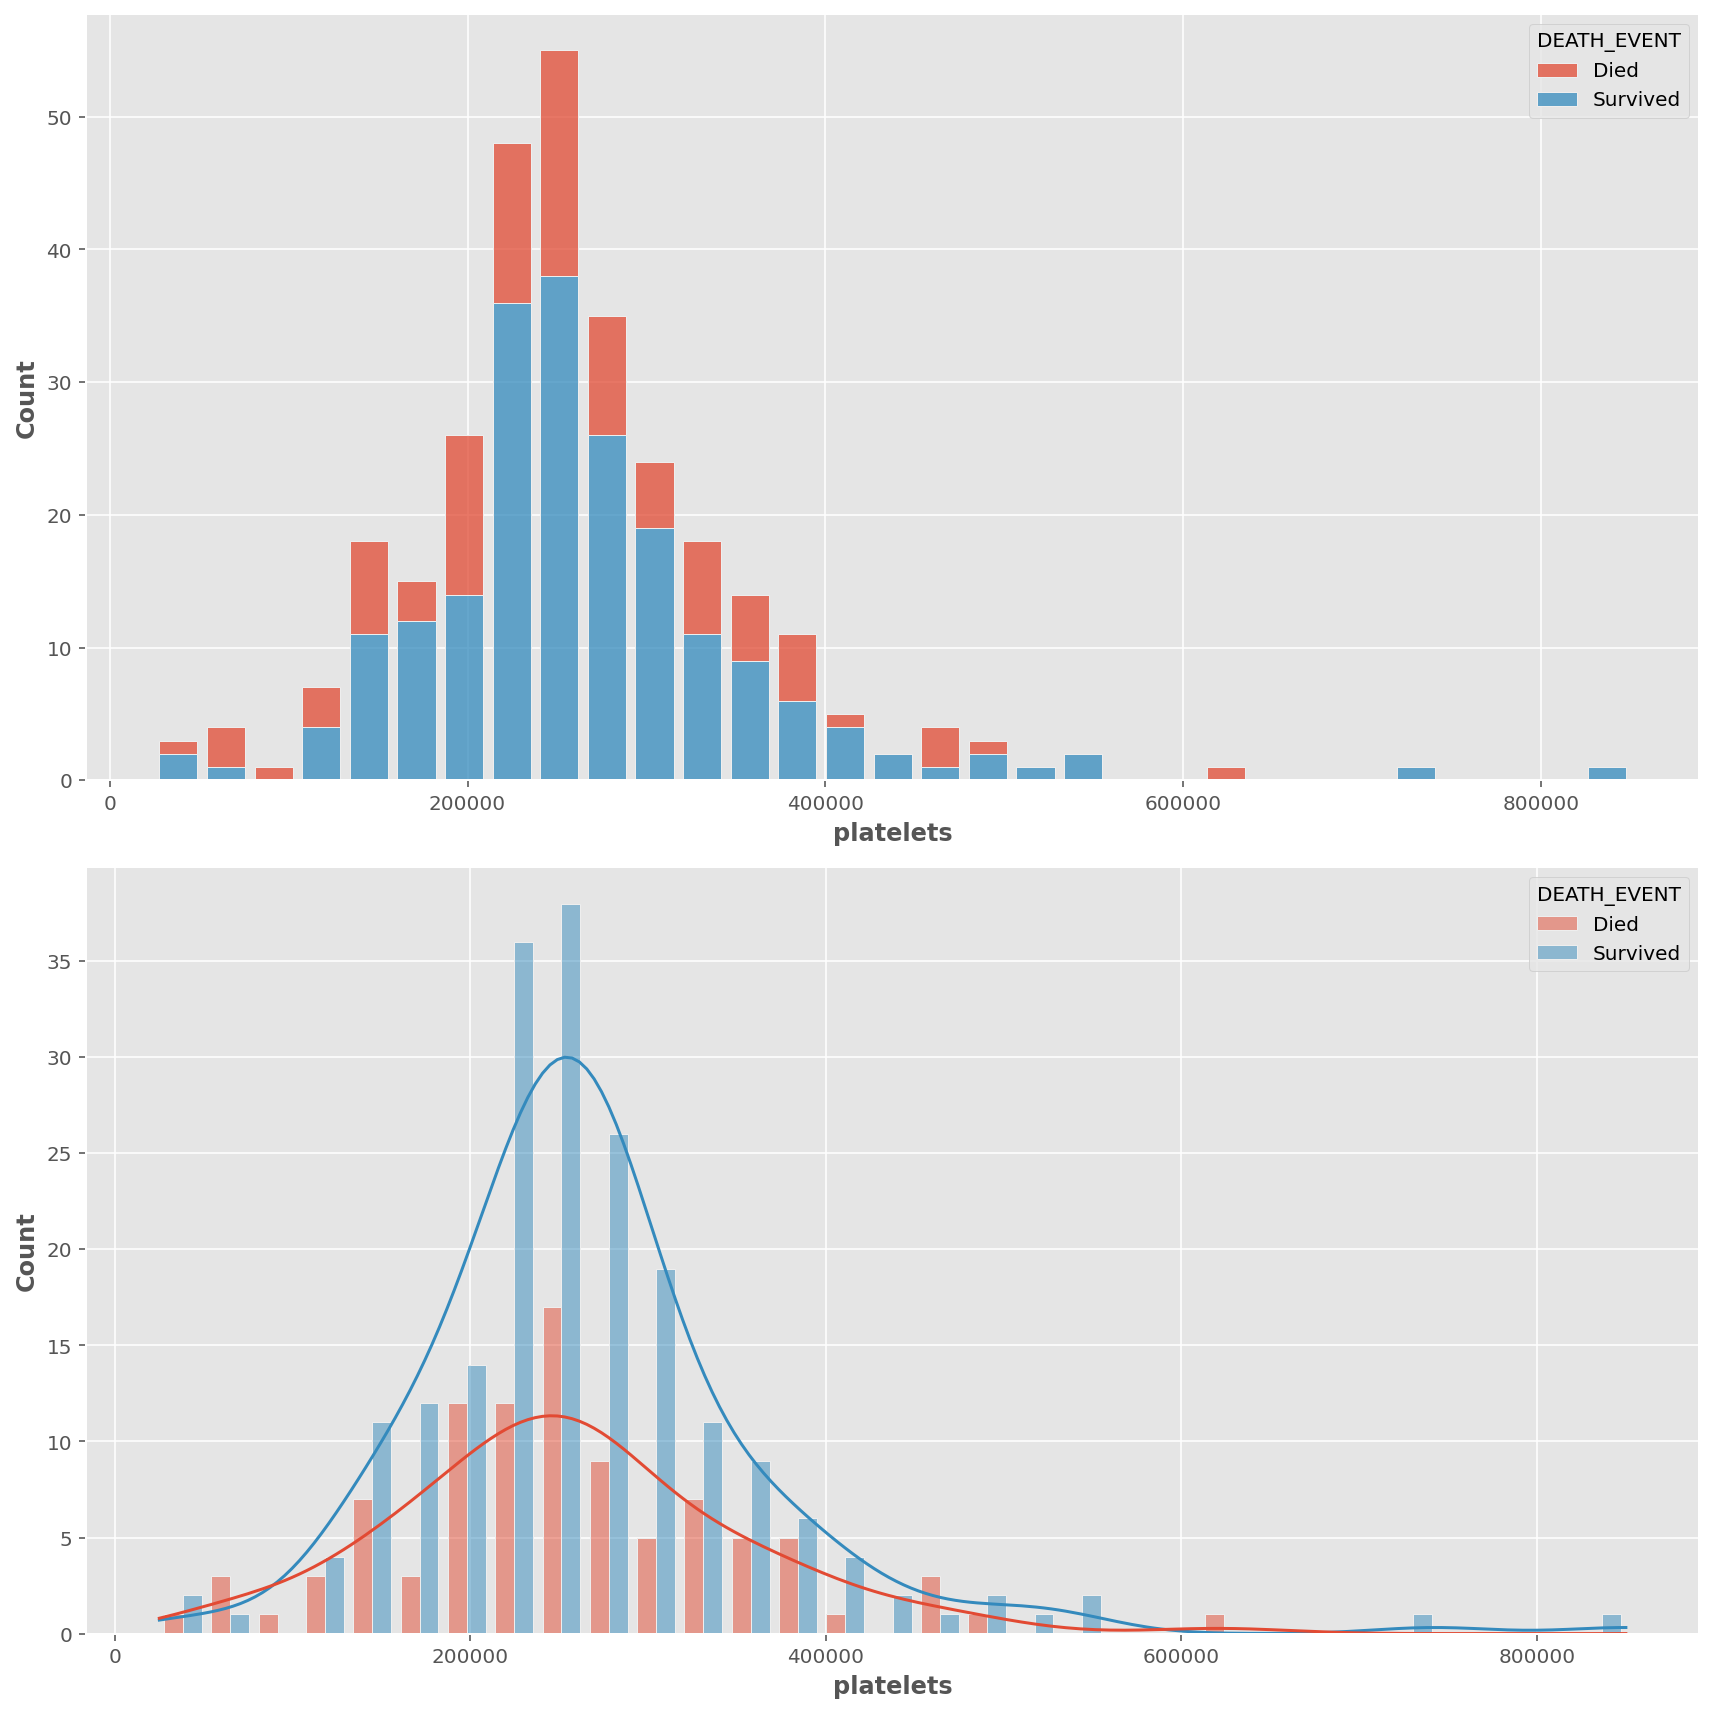

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="platelets", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="platelets",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)

<AxesSubplot:xlabel='platelets', ylabel='Density'>

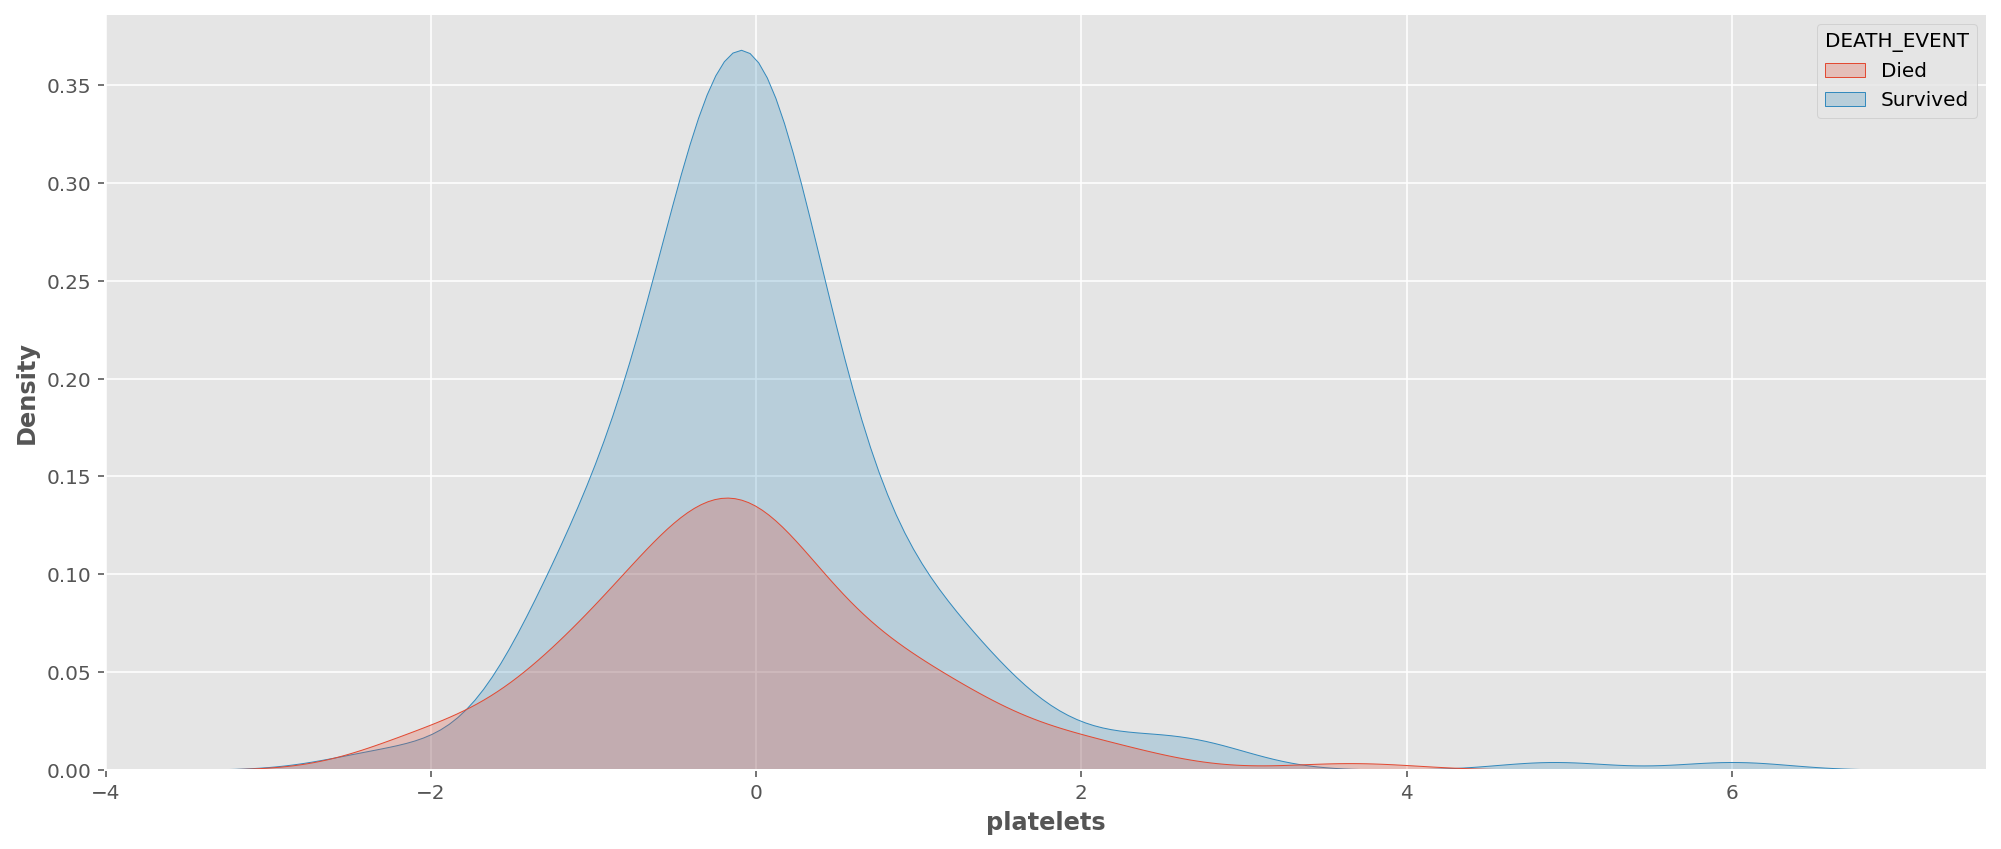

In [20]:
std =stats.zscore(plot_heart_data.platelets)
plt.figure(figsize=(14, 6))
sns.kdeplot(data=plot_heart_data, x = std, hue="DEATH_EVENT",shade=True) #x = std for distribution

<AxesSubplot:xlabel='serum_creatinine', ylabel='Count'>

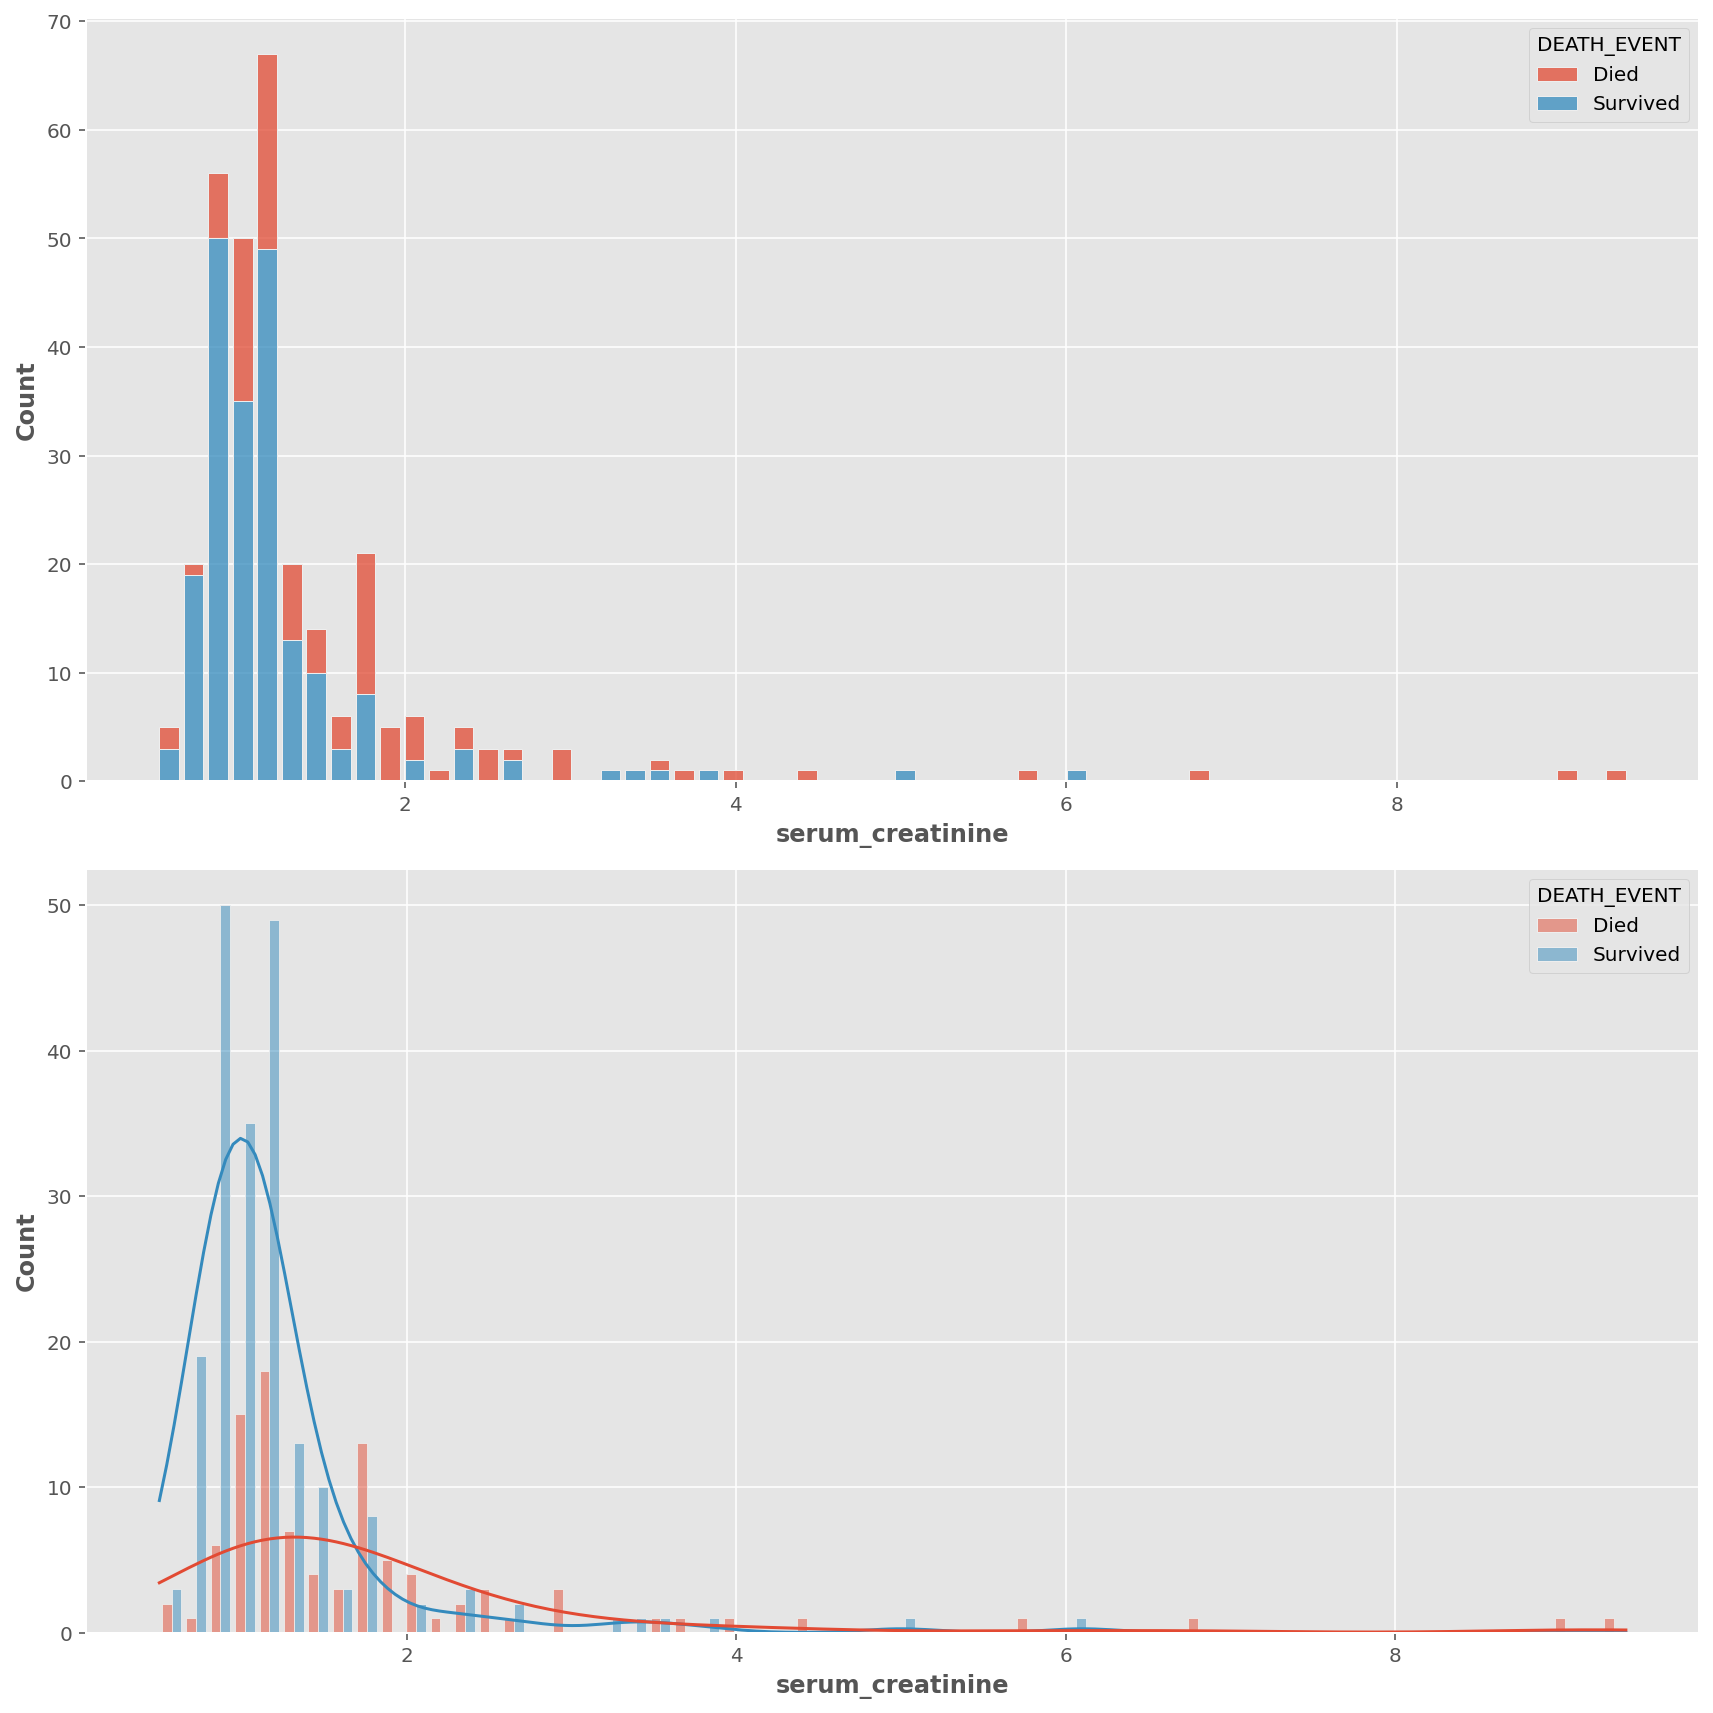

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="serum_creatinine", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="serum_creatinine",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)

<AxesSubplot:xlabel='serum_creatinine', ylabel='Density'>

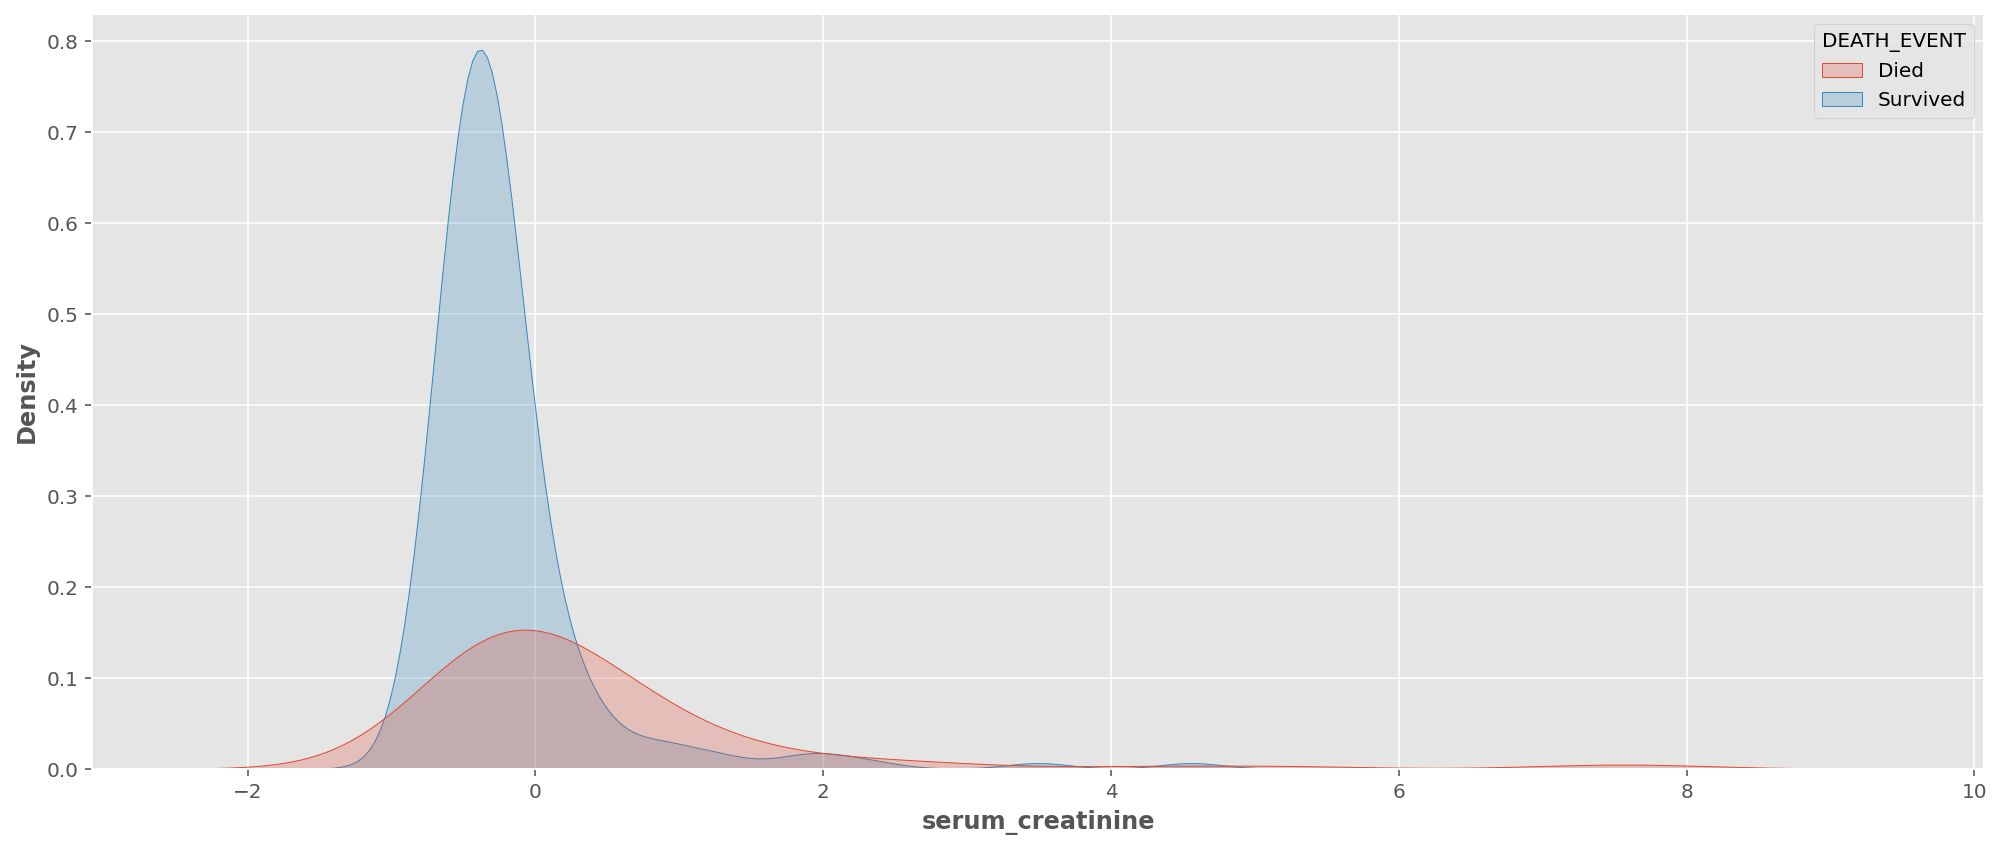

In [22]:
std =stats.zscore(plot_heart_data.serum_creatinine)
plt.figure(figsize=(14, 6))
sns.kdeplot(data=plot_heart_data, x = std, hue="DEATH_EVENT",shade=True) #x = std for distribution

<AxesSubplot:xlabel='serum_sodium', ylabel='Count'>

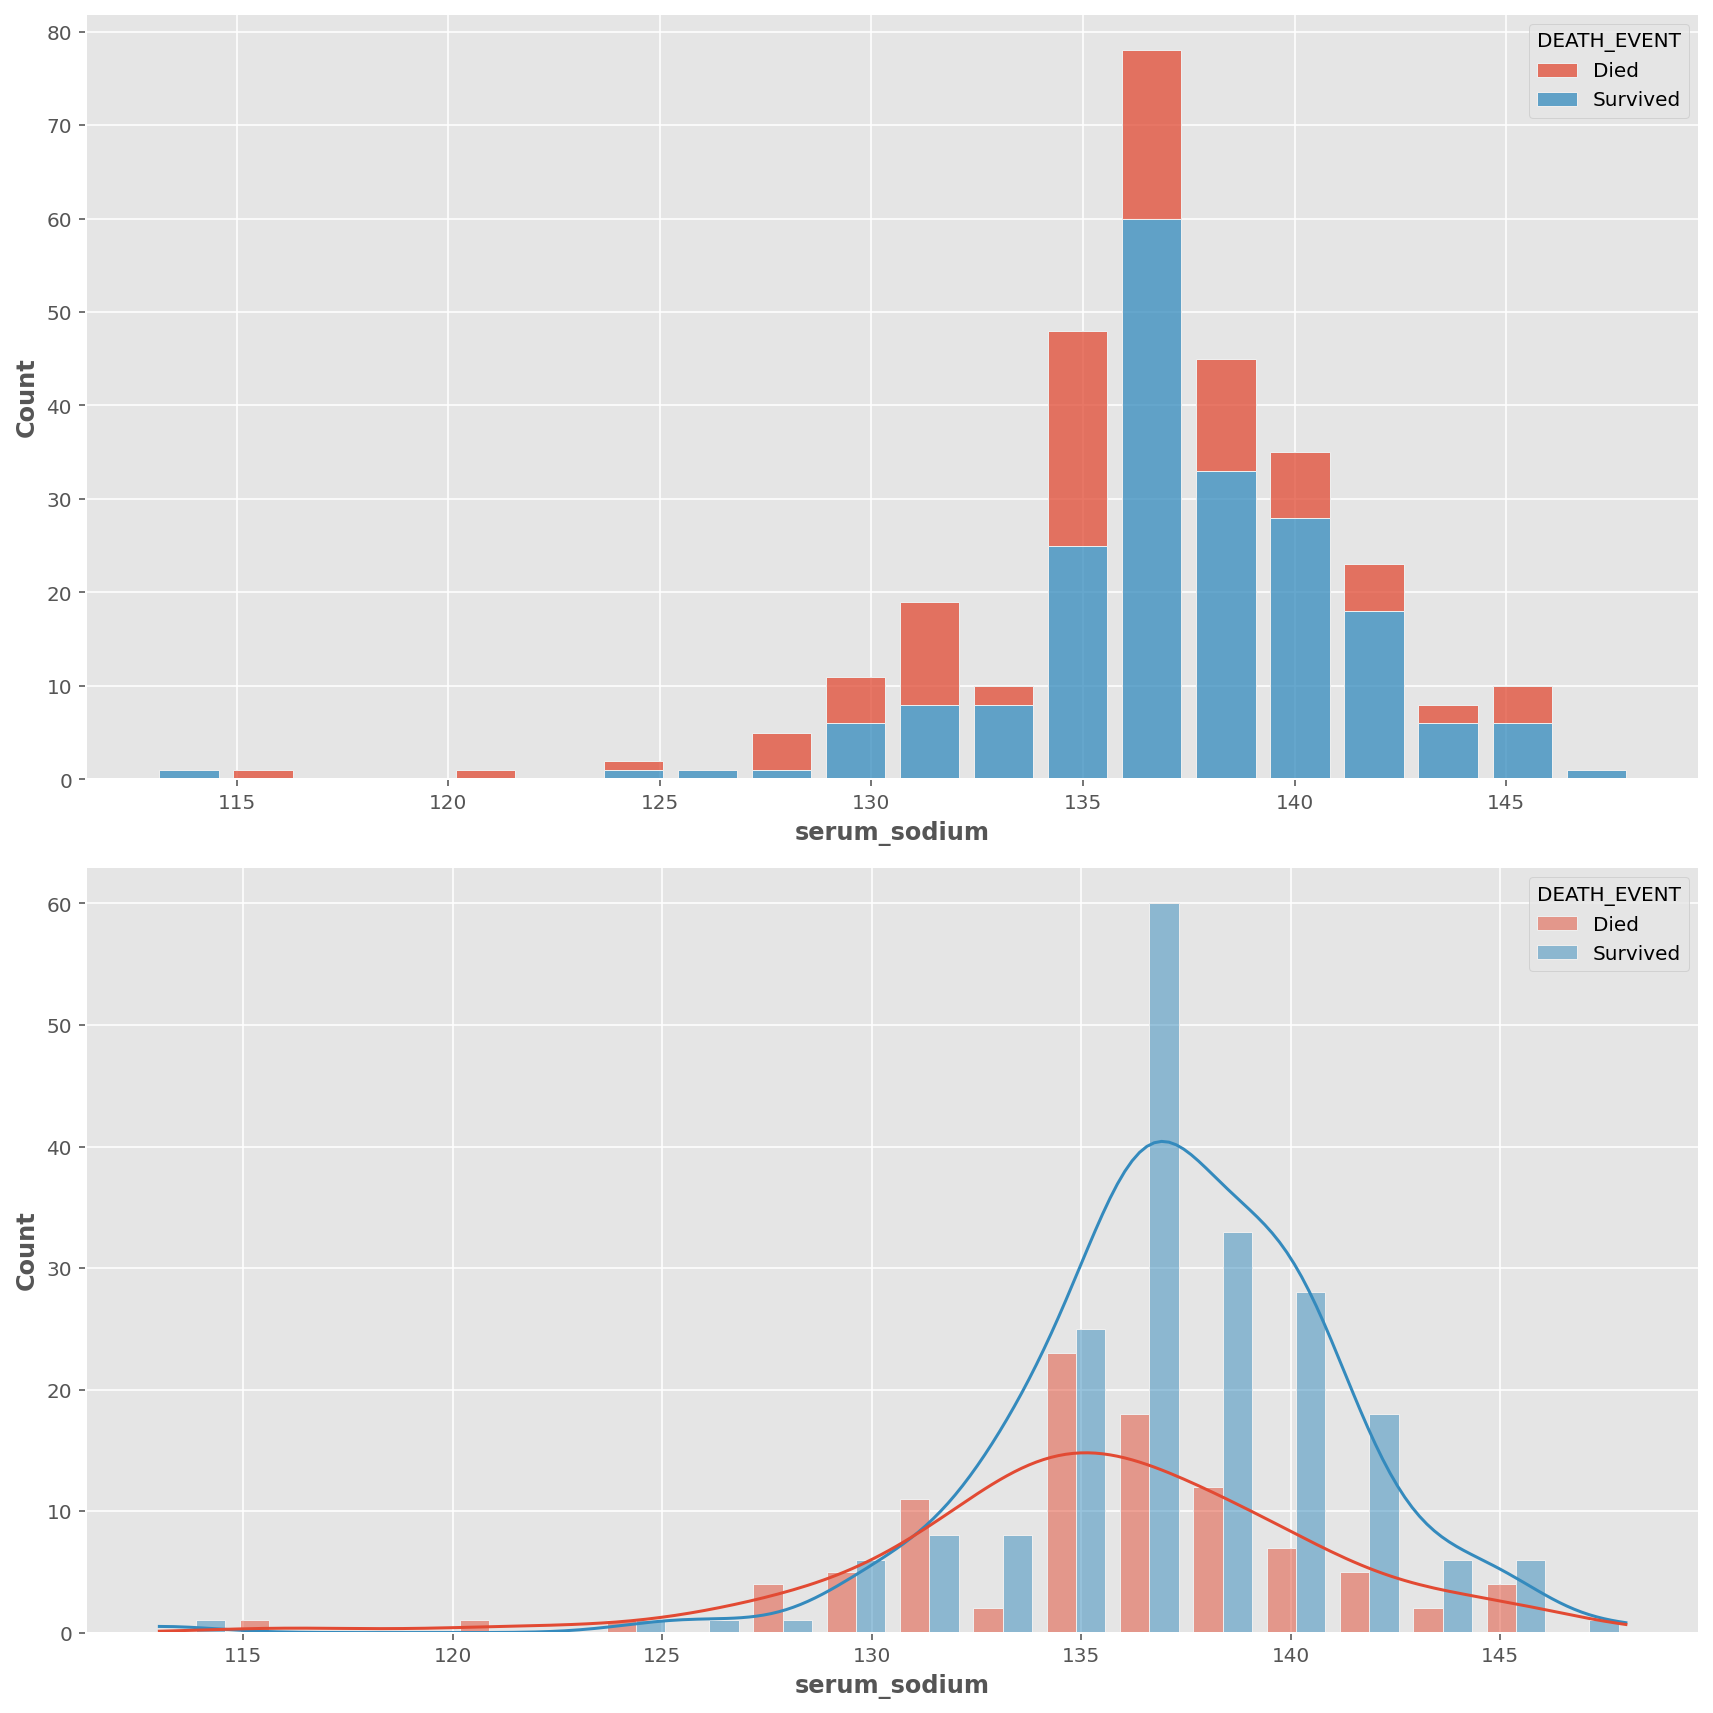

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="serum_sodium", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="serum_sodium",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)

Longest follow-up time was 285 days
79.17% of dead patients died within 120 days of follow-up
25.42% of patients died within 120 days of follow-up


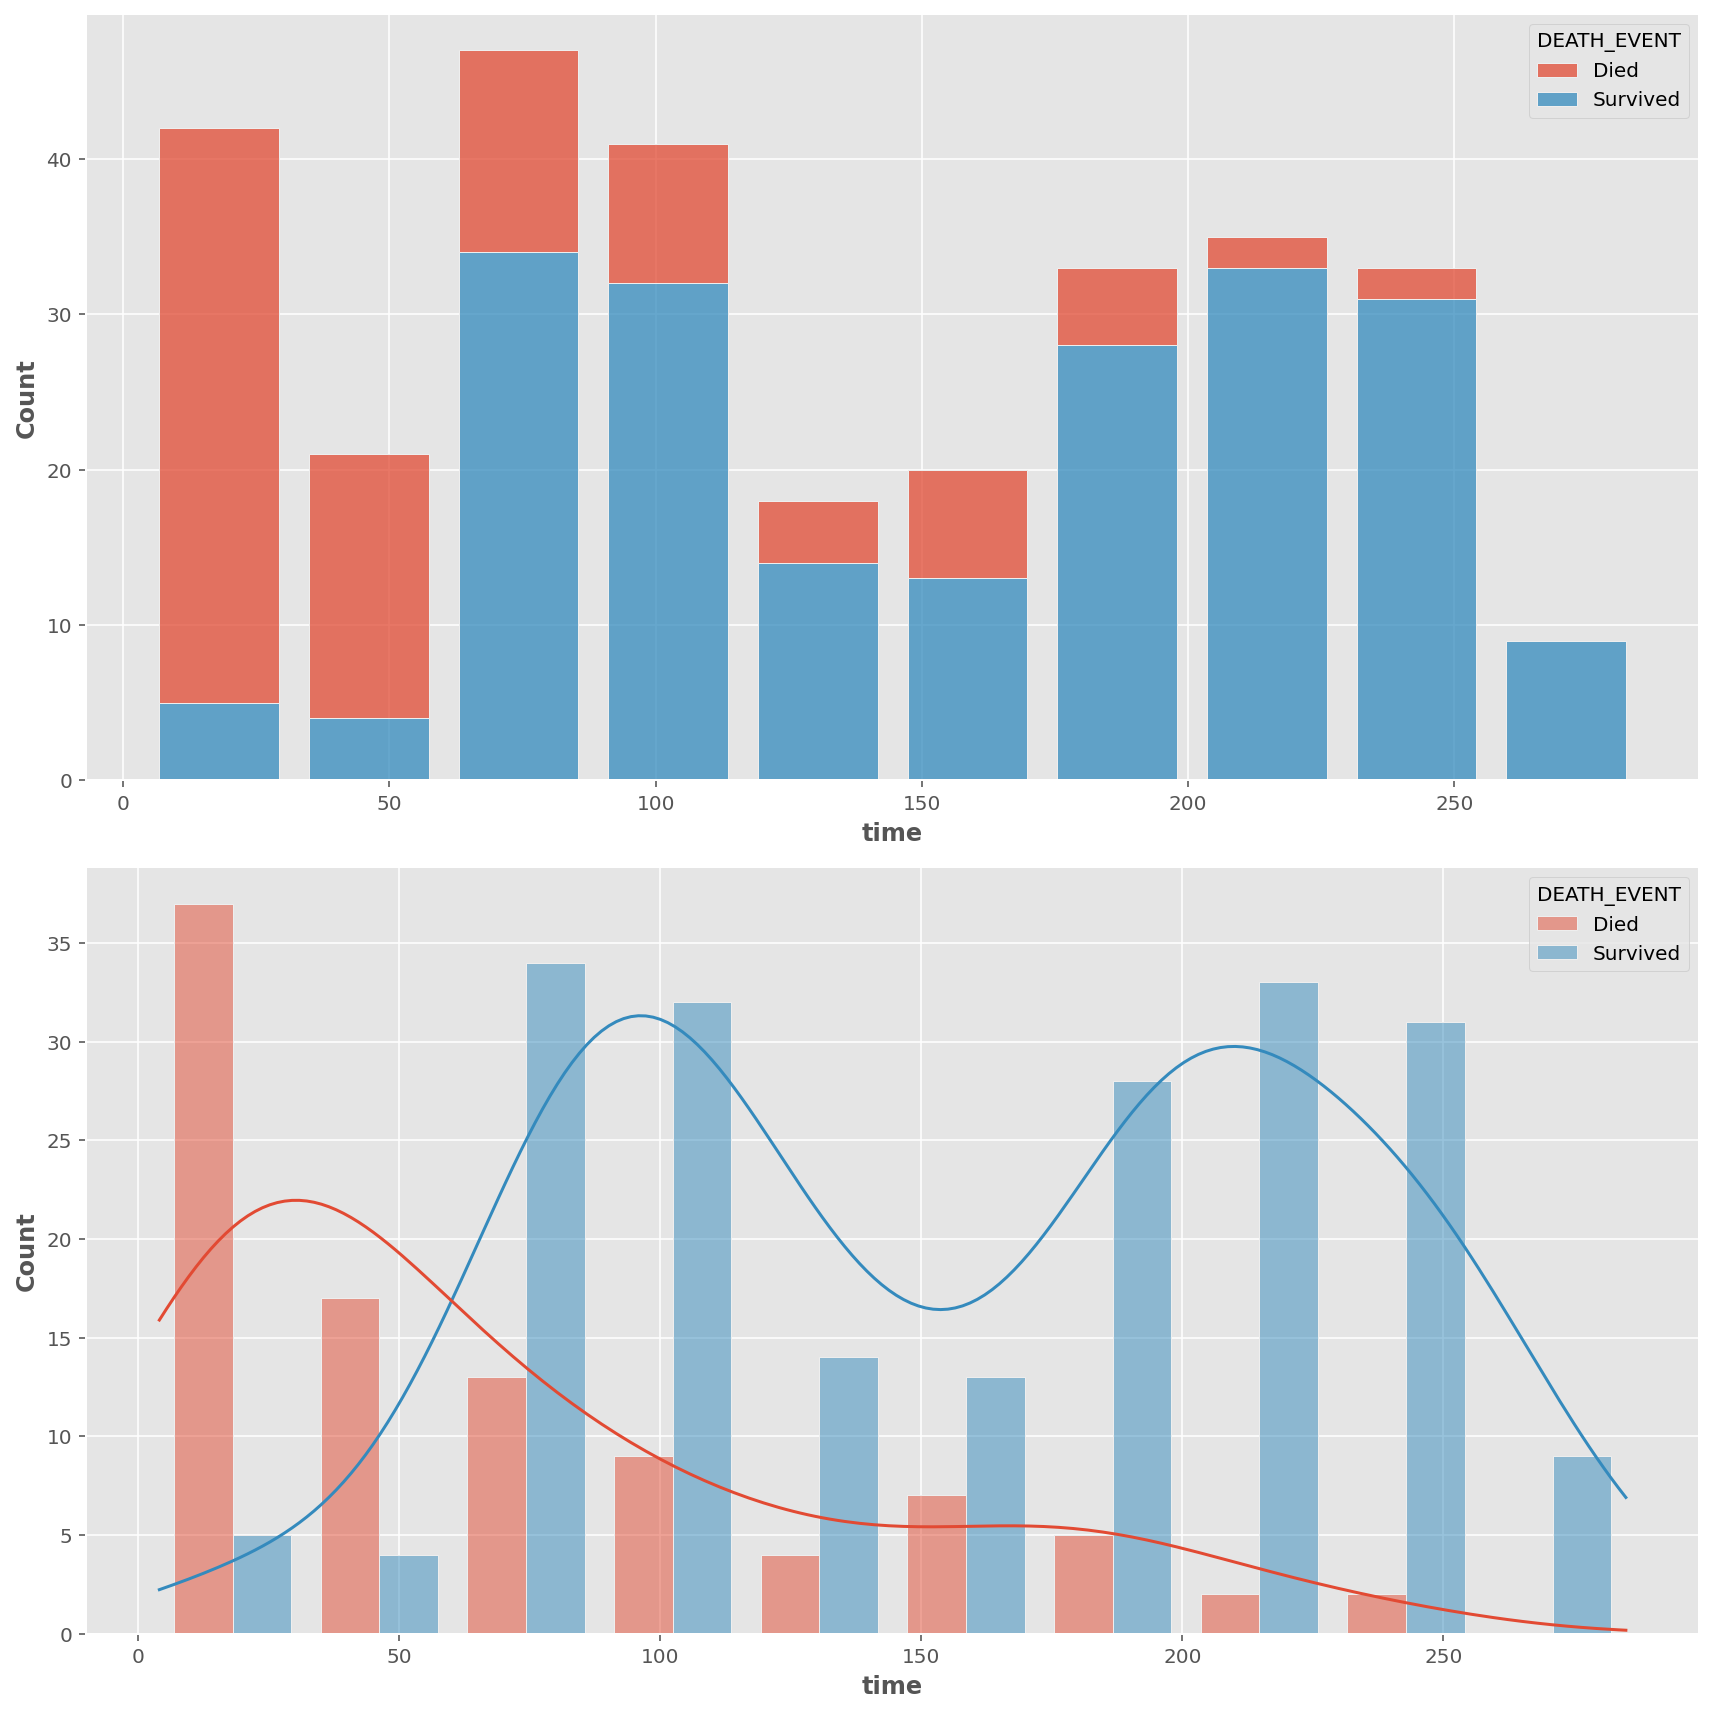

In [24]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_heart_data, x="time", hue="DEATH_EVENT", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_heart_data, x="time",multiple="dodge", shrink=.8, hue="DEATH_EVENT",ax=ax2,  kde = True)
print(f'Longest follow-up time was {max(heart_data.time)} days')
print(f'{round(len(heart_data[(heart_data.time<=120) & (heart_data.DEATH_EVENT == 1)])/len((heart_data[heart_data.DEATH_EVENT==1]))*100,2)}% of dead patients died within 120 days of follow-up')
print(f'{round(len(heart_data[(heart_data.time<=120) & (heart_data.DEATH_EVENT == 1)])/len(heart_data)*100,2)}% of patients died within 120 days of follow-up')

In [25]:
#sns.pairplot(plot_heart_data,hue = 'DEATH_EVENT')

Text(0.5, 1.0, 'Features correlation with Death Event')

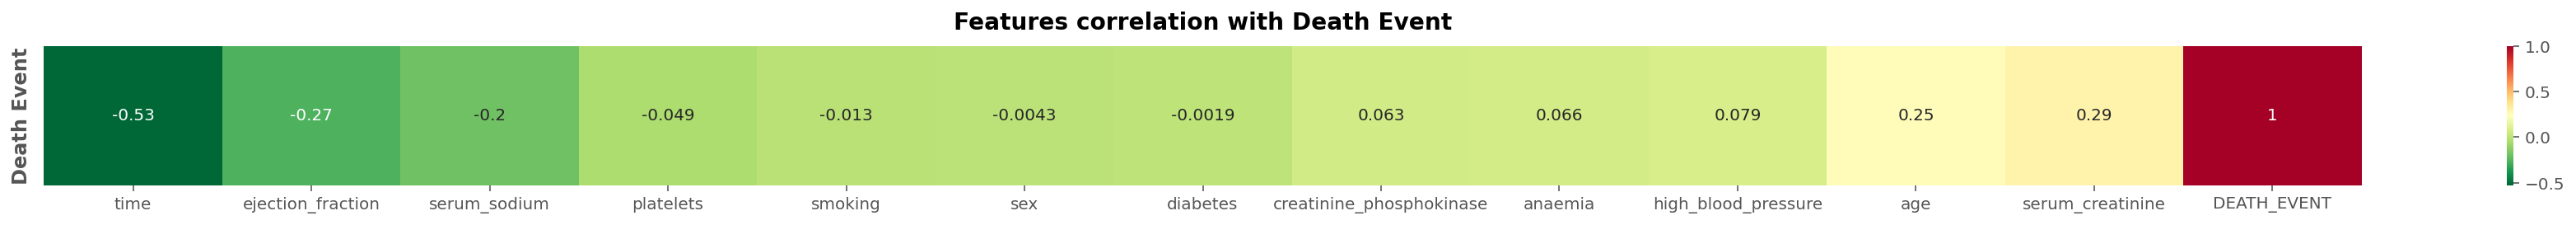

In [26]:
corr = heart_data.corrwith(heart_data.DEATH_EVENT).sort_values()
plt.figure(figsize=(25,2))
sns.heatmap(corr.to_frame().T,
            cmap='RdYlGn_r',
            annot=True,
)
plt.yticks([])
plt.ylabel('Death Event')
plt.title('Features correlation with Death Event')

### Model Building

In [27]:
X = heart_data.drop(['DEATH_EVENT'], axis=1)
y = heart_data.DEATH_EVENT
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00000,1.900391,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03125,1.099609,136,1,0,6
2,65.0,0,146,0,20,0,162000.00000,1.299805,129,1,1,7
3,50.0,1,111,0,20,0,210000.00000,1.900391,137,1,0,7
4,65.0,1,160,1,20,0,327000.00000,2.699219,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00000,1.099609,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00000,1.200195,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00000,0.799805,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00000,1.400391,140,1,1,280


## Log Transformation

In [28]:
wide_var=['ejection_fraction', 'serum_sodium','platelets','creatinine_phosphokinase','serum_creatinine']
def log_transform(x):
    return np.log(x)

In [29]:
X[wide_var] =  X[wide_var].apply(log_transform)
X.sample(15)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
11,62.0,0,5.442418,0,3.218750,1,12.441145,-0.105469,4.941642,1,1,10
197,65.0,0,5.117994,0,3.400391,0,12.464583,-0.223389,4.927254,0,0,186
67,72.0,1,4.700480,0,3.218750,0,12.520884,0.000000,4.941642,1,1,65
87,65.0,1,4.219508,1,4.093750,1,12.624783,-0.223389,4.941642,1,0,79
60,45.0,0,8.949235,1,3.218750,1,12.873902,0.000000,4.934474,1,0,60
175,60.0,1,4.553877,0,4.093750,0,12.727839,0.000000,4.927254,1,1,146
127,58.0,1,5.298317,1,4.093750,0,12.611538,-0.223389,4.919981,0,0,104
52,60.0,0,8.285009,1,4.128906,0,12.481270,1.916992,4.983607,0,0,43
85,51.0,0,4.356709,0,3.912109,0,12.914108,-0.356445,4.941642,1,0,79
6,75.0,1,5.505332,0,2.708984,0,11.751943,0.182495,4.919981,1,0,10


In [30]:
from imblearn.over_sampling import RandomOverSampler
X,y=RandomOverSampler().fit_resample(X,y)
#X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=1)

In [31]:
# optimized parameters
cb_params = {'iterations': 10000,
             'learning_rate': 0.10541740827465951,
             'loss_function': 'MultiClass',
             'eval_metric': 'Accuracy',
             'l2_leaf_reg': 7.9244600994516805,
             'depth': 4.0,
             'leaf_estimation_method': 'Gradient',
             'od_type': 'Iter',
             'early_stopping_rounds': 300,
             'border_count': 206,
             'use_best_model': True,
             'task_type': 'GPU',}

In [32]:
%%time
# Setting up fold parameters
splits = 5
skf = model_selection.StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)




# Creating an array of zeros for storing "out of fold" predictions
oof_preds = np.zeros((X.shape[0],))

model_fi = 0
total_mean_acc = 0
scaler=StandardScaler()
# Generating folds and making training and prediction for each of 10 folds
for num, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
#     X_train[wide_var]=scaler.fit_transform(X_train[list(wide_var)])
#     X_valid[wide_var]=scaler.transform(X_valid[list(wide_var)])
    model = CatBoostClassifier(**cb_params)
    model.fit(X_train, y_train,
              verbose=False,
              eval_set=(X_valid, y_valid),
              )
    
    # Getting mean feature importances
    model_fi += model.feature_importances_ / splits
    
    # Getting validation data predictions.     
    oof_preds[valid_idx] = model.predict(X_valid).flatten()
    
    # Getting score for a fold model
    fold_acc = accuracy_score(y_valid, oof_preds[valid_idx])
    
    print(f"Fold {num} accuracy: {fold_acc}")
    print(classification_report(y_valid,oof_preds[valid_idx]))
    
    # Getting mean score of all fold models 
    total_mean_acc += fold_acc / splits
    
print(f"\nOverall ROC AUC: {total_mean_acc}")

Fold 0 accuracy: 0.9390243902439024
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        41
           1       0.89      1.00      0.94        41

    accuracy                           0.94        82
   macro avg       0.95      0.94      0.94        82
weighted avg       0.95      0.94      0.94        82

Fold 1 accuracy: 0.9135802469135802
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        40
           1       0.89      0.95      0.92        41

    accuracy                           0.91        81
   macro avg       0.92      0.91      0.91        81
weighted avg       0.92      0.91      0.91        81

Fold 2 accuracy: 0.9259259259259259
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.93      0.93      0.93        41

    accuracy                           0.93        81
   macro avg       0

In [33]:
# skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
# lst_accu_stratified = []
  
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     model = CatBoostClassifier(**cb_params)
#     model.fit(X_train, y_train,
#               verbose=False,
#               eval_set=(X_test, y_test),
#               )
#     lst_accu_stratified.append(model.score(X_test, y_test))
  
# # Print the output.
# print('List of possible accuracy:', lst_accu_stratified)
# print('\nMaximum Accuracy That can be obtained from this model is:',
#       max(lst_accu_stratified)*100, '%')
# print('\nMinimum Accuracy:',
#       min(lst_accu_stratified)*100, '%')
# print('\nOverall Accuracy:',
#      sum(lst_accu_stratified)/len(lst_accu_stratified)*100, '%')

<function matplotlib.pyplot.show(close=None, block=None)>

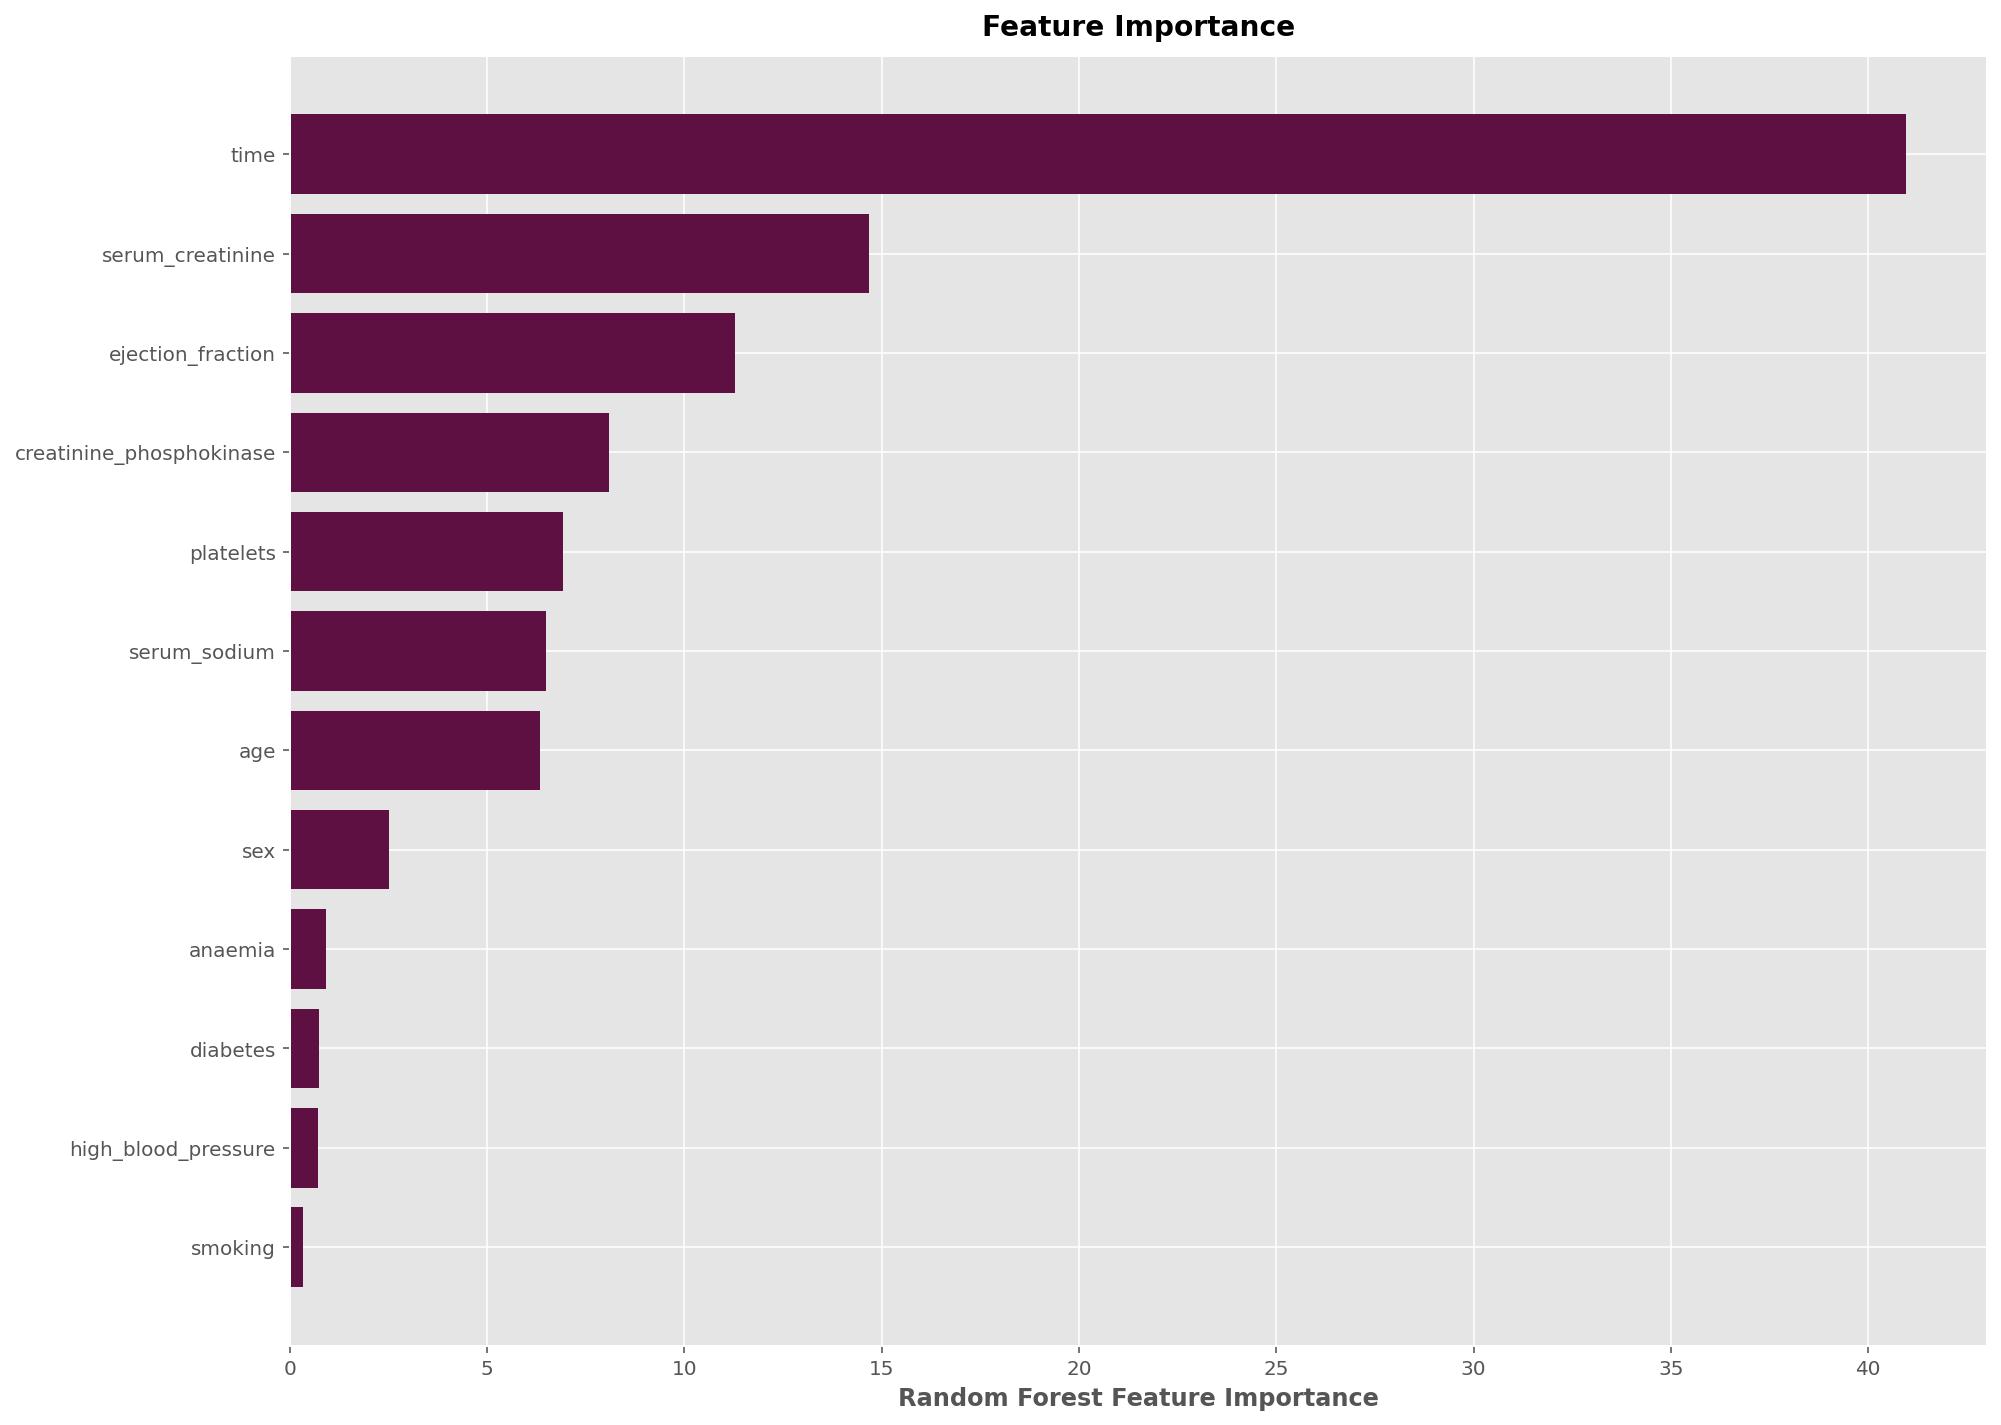

In [34]:
plt.figure(figsize=(14,10))
idxs = np.argsort(model_fi)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),model_fi[idxs],align="center",color = '#5f1042')
plt.yticks(range(len(idxs)),[X_train.columns[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
plt.tight_layout()
plt.show

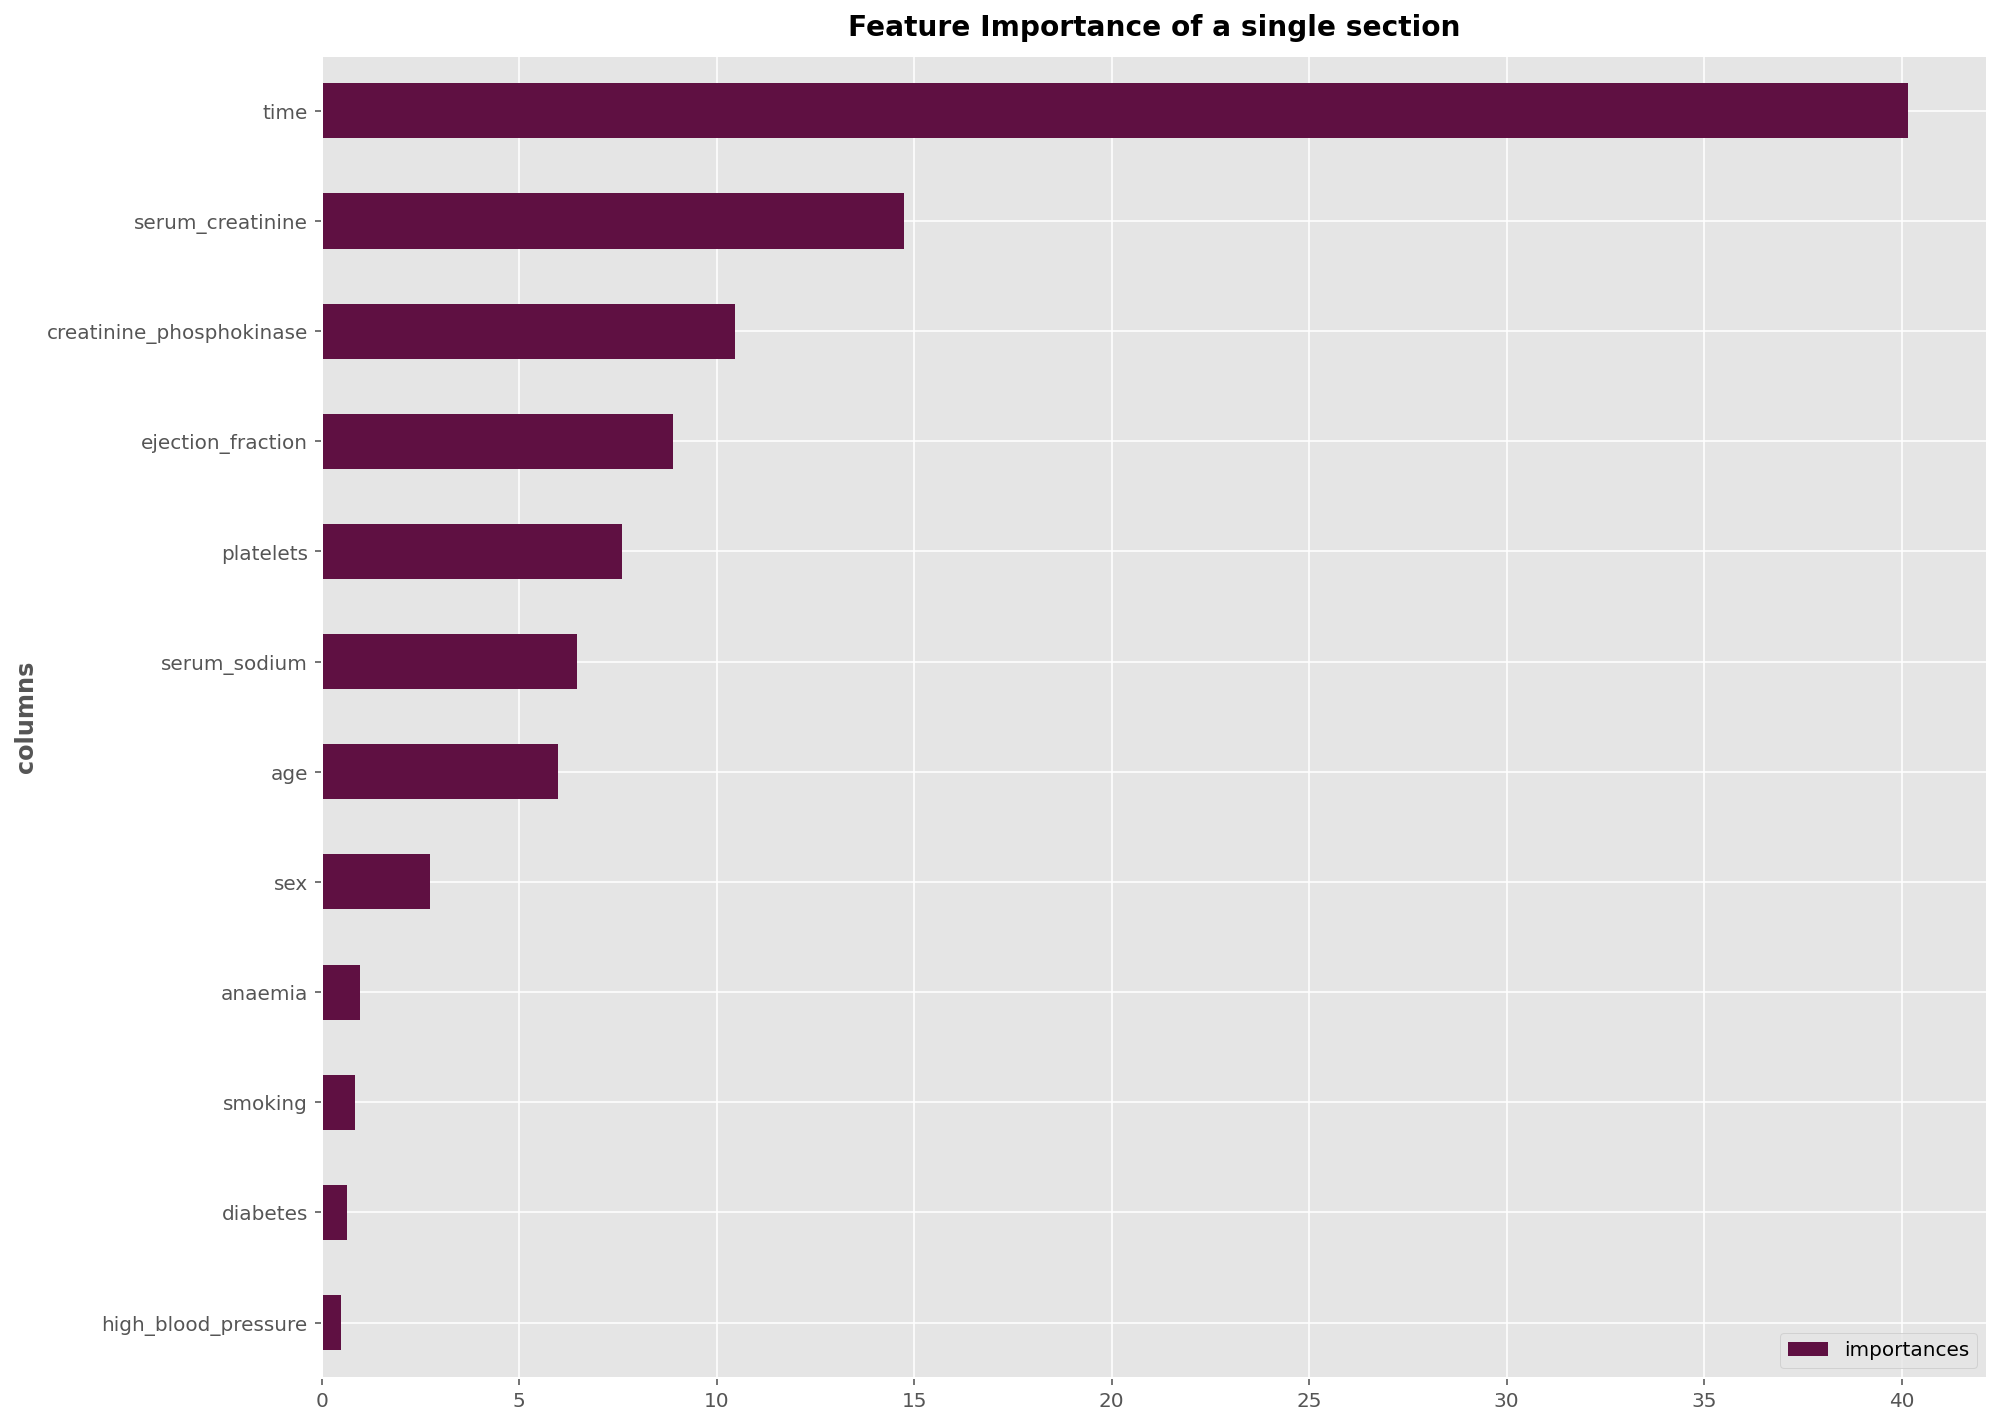

In [35]:
fi = (pd.DataFrame({'importances': model.feature_importances_, 
                        'columns': X_train.columns})
          .sort_values(['importances', 'columns'], ascending=[True, False])
          .plot(kind = 'barh', 
                x='columns', 
                y='importances', 
                figsize=(14, 10),
                color = '#5f1042'))
plt.title("Feature Importance of a single section")
plt.show()